In [1]:
import pandas as pd
import os
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown

import sys
sys.path.append('../')

from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from utilities import data, roc, threshold, output, info
from utilities.info import *

In [2]:
FIG_DIR = f"{TEAMS_DIR}/melba-figs"
TAB_DIR = f"{TEAMS_DIR}/melba-tables"

print("FILES:\t", FILE_DIR)
print("RESULT:\t", RESULTS_DIR)
print("FIGS:\t", FIG_DIR)
print("TABLES:\t", TAB_DIR)

FILES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/files
RESULT:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/fairness-analysis-results
FIGS:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/melba-figs
TABLES:	 C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/melba-tables


In [3]:
POLICIES_TO_USE = ['90% Sensitivity', '90% Specificity', 'Brock ILST (6%)']
TABLE_SCORE_PRECISION = 2
MIN_MAL = 15
TOP_N_CONFOUNDERS = 10

In [4]:
nlst_preds_nodule = pd.read_csv(f"{FILE_DIR}/nlst_allmodels_demos.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 127 entries, PatientID to study
dtypes: bool(27), float64(85), int64(11), object(4)
memory usage: 12.7+ MB


In [5]:
with open(f'{FILE_DIR}/nlst_democols.json') as json_data:
    nlst_democols_og = json.load(json_data)
    json_data.close()

nlst_democols_og

{'num': {'demo': ['weight', 'height', 'BMI', 'Age'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'nodule': ['CoordX', 'CoordY', 'CoordZ'],
  'other': ['Diameter_mm', 'NoduleCounts']},
 'cat': {'demo': ['Overweight',
   'race',
   'ethnic',
   'Unfinished_ed',
   'educat',
   'NonHispanicWhite',
   'WhiteOrBlack',
   'marital',
   'Married',
   'HighSchoolPlus',
   'Gender'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop

# Materials

## Demographic characteristics of the NLST validation set (n=5911 scans).

In [88]:
nlst_5911, nlst_democols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=True, bin_num=False)
len(nlst_5911)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


5911

In [89]:
nlst_5911['PatientID'].nunique()

3492

In [90]:
nlstval_full_mal = nlst_5911.query('label == 1')
nlstval_full_ben = nlst_5911.query('label == 0')
print('full:', len(nlstval_full_ben), 'ben', len(nlstval_full_mal), 'mal')

full: 5330 ben 581 mal


In [91]:
validation_sets = {
    "Full (malignant)": nlstval_full_mal,
    "Full (benign)": nlstval_full_ben,
    "Full (all)": nlst_5911,
}

In [92]:
cat_df0 = data.combine_diff_dfs(nlst_democols['cat'], data.diffs_category_prevalence, validation_sets)
cat_df = cat_df0.copy(deep=True)
for s in validation_sets:
    cat_df[f"{s}_info"] = cat_df.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_df = cat_df[['category', 'attribute', 'value'] + [f"{s}_info" for s in validation_sets]].dropna(axis=0)
cat_df = cat_df.set_index(pd.MultiIndex.from_frame(cat_df[['category', 'attribute', 'value']]))[[f"{s}_info" for s in validation_sets]]

In [93]:
attribute_valid_subgroups_5911 = cat_df0[cat_df0['Full (malignant)_freq'] > 15][['attribute', 'value', 'Full (malignant)_freq']].groupby('attribute')['value'].count()
invalid_attributes_5911 = list(attribute_valid_subgroups_5911[attribute_valid_subgroups_5911 < 2].index)

total_categorical_columns = cat_df0['attribute'].nunique()
print("invalid:", len(invalid_attributes_5911))
print("valid:", total_categorical_columns - len(invalid_attributes_5911))

invalid: 36
valid: 47


In [94]:
num_df = data.combine_diff_dfs(nlst_democols['num'], data.diffs_numerical_means, validation_sets)
num_df = num_df[(num_df['value'].isin(['Median (IQR)']))][['category', 'attribute', 'value'] + [f"{s}" for s in validation_sets]].dropna(axis=0)
num_df = num_df.set_index(pd.MultiIndex.from_frame(num_df[['category', 'attribute', 'value']]))[[f"{s}" for s in validation_sets]]

In [95]:
# multicol_idx = pd.MultiIndex.from_tuples([
#     ('NLST Dataset (n=5911 Scans)', 'Malignant (n=581)'),
#     ('NLST Dataset (n=5911 Scans)', 'Benign (n=5330)'),
#     ('NLST Dataset (n=5911 Scans)', 'Total'),
# ])
multicol_idx = pd.Index([
    'Malignant (n=581)',
    'Benign (n=5330)',
    'All Scans (n=5911)',
])

cat_df.columns = multicol_idx
num_df.columns = multicol_idx

In [96]:
df_out = pd.concat([cat_df, num_df], axis=0)
df_out

Malignant (n=581)  \
category     attribute              value                                  
Demographics BMI                    < 25                      209 (36.0)   
                                    ≥ 25                      372 (64.0)   
             Race                   Asian                        6 (1.0)   
                                    Black                       28 (4.8)   
                                    More than one race           6 (1.0)   
...                                                                  ...   
Smoking      Age at Smoking Onset   Median (IQR)                  16 (4)   
             Cigarettes per Day     Median (IQR)                 30 (20)   
             Total Years of Smoking Median (IQR)                 44 (10)   
Other        Diameter (mm)          Median (IQR)                  12 (9)   
             Nodules Per Scan       Median (IQR)                   2 (2)   

                                                       Benign (n=5330)  \
category     attribute              value                                
Demographics BMI                    < 25                   1690 (31.7)   
                                    ≥ 25                   3640 (68.3)   
             Race                   Asian                     66 (1.2)   
                                    Black                    160 (3.0)   
                                    More than one race        59 (1.1)   
...                                                                ...   
Smoking      Age at Smoking Onset   Median (IQR)                16 (3)   
             Cigarettes per Day     Median (IQR)               25 (15)   
             Total Years of Smoking Median (IQR)               41 (10)   
Other        Diameter (mm)          Median (IQR)                 6 (4)   
             Nodules Per Scan       Median (IQR)                 1 (1)   

                                                       All Scans (n=5911)  
category     attribute              value                                  
Demographics BMI                    < 25                      1899 (32.1)  
                                    ≥ 25                      4012 (67.9)  
             Race                   Asian                        72 (1.2)  
                                    Black                       188 (3.2)  
                                    More than one race           65 (1.1)  
...                                                                   ...  
Smoking      Age at Smoking Onset   Median (IQR)                   16 (4)  
             Cigarettes per Day     Median (IQR)                  25 (15)  
             Total Years of Smoking Median (IQR)                  41 (10)  
Other        Diameter (mm)          Median (IQR)                    7 (5)  
             Nodules Per Scan       Median (IQR)                    1 (1)  

[192 rows x 3 columns]

In [97]:
demos_no_duplicates = [data.rename_cols[c] for c in ['race','ethnic','educat','Gender','weight', 'height', 'BMI', 'Age']]
df_out2 = df_out.xs('Demographics', level='category').query("attribute in @demos_no_duplicates")
df_out2

Malignant (n=581) Benign (n=5330)  \
attribute        value                                                   
Race             Asian                         6 (1.0)        66 (1.2)   
                 Black                        28 (4.8)       160 (3.0)   
                 More than one race            6 (1.0)        59 (1.1)   
                 Native American               8 (1.4)        15 (0.3)   
                 Native Hawaiian               1 (0.2)        17 (0.3)   
                 White                      530 (91.2)     4993 (93.7)   
Ethnicity        Hispanic/Latino               4 (0.7)        94 (1.8)   
                 Not Hispanic/Latino        574 (98.8)     5205 (97.7)   
Education Status 8th grade or less             9 (1.5)       102 (1.9)   
                 9th-11th grade               32 (5.5)       258 (4.8)   
                 Associate Degree           126 (21.7)     1175 (22.0)   
                 Bachelors Degree            96 (16.5)      817 (15.3)   
                 Graduate School             76 (13.1)      778 (14.6)   
                 HS Graduate / GED          141 (24.3)     1338 (25.1)   
                 Post-HS training            87 (15.0)      765 (14.4)   
Sex              Female                     244 (42.0)     2226 (41.8)   
                 Male                       337 (58.0)     3104 (58.2)   
Weight           Median (IQR)                 175 (50)        180 (50)   
Height           Median (IQR)                   68 (6)          68 (6)   
Body Mass Index  Median (IQR)                   26 (4)          27 (6)   
Age              Median (IQR)                   64 (8)          62 (8)   

                                     All Scans (n=5911)  
attribute        value                                   
Race             Asian                         72 (1.2)  
                 Black                        188 (3.2)  
                 More than one race            65 (1.1)  
                 Native American               23 (0.4)  
                 Native Hawaiian               18 (0.3)  
                 White                      5523 (93.4)  
Ethnicity        Hispanic/Latino               98 (1.7)  
                 Not Hispanic/Latino        5779 (97.8)  
Education Status 8th grade or less            111 (1.9)  
                 9th-11th grade               290 (4.9)  
                 Associate Degree           1301 (22.0)  
                 Bachelors Degree            913 (15.4)  
                 Graduate School             854 (14.4)  
                 HS Graduate / GED          1479 (25.0)  
                 Post-HS training            852 (14.4)  
Sex              Female                     2470 (41.8)  
                 Male                       3441 (58.2)  
Weight           Median (IQR)                  180 (50)  
Height           Median (IQR)                    68 (6)  
Body Mass Index  Median (IQR)                    26 (6)  
Age              Median (IQR)                    62 (8)

In [98]:
print(df_out2.style.format(precision=1, na_rep='-').format_index(output.latex_replace_arrowbrackets).format(output.latex_replace_arrowbrackets).to_latex(
    buf=f"{TAB_DIR}/datasetDemos.tex",
    hrules=True, label='tab:datasetDemos', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the NLST validation set (n={len(nlst_5911)} scans). HS = High School.'))

None


## DLCST vs. NLST

NOTE: unused in MELBA paper right now. If we want to have DLCST, then we should probably keep this in.

In [17]:
nlst_valset, nlst_cols, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=True, bin_num=False)
dlcst_preds = pd.read_csv(f"{FILE_DIR}/dlcst_allmodels_cal.csv", header=0)
dlcst_valset, dlcst_cols = data.nlst_pretty_labels(dlcst_preds, DLCST_DEMOCOLS)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [18]:
popshift_check = {
    "NLST_mal": nlst_valset.query('label == 1'),
    "NLST_ben": nlst_valset.query('label == 0'),
    # "NLST_full": nlst_valset,
    "DLCST_mal": dlcst_valset.query('label == 1'),
    "DLCST_ben": dlcst_valset.query('label == 0'),
    # "DLCST_full": dlcst_valset,   
}

popshift_multi_idx = pd.MultiIndex.from_tuples([
    ('NLST Validation (n=5911 Scans)', 'Malignant (n=581)'),
    ('NLST Validation (n=5911 Scans)', 'Benign (n=5330)'),
    # ('NLST Validation (n=5911 Scans)', 'Total'),
    ('DLCST Validation (n=599 Scans)', 'Malignant (n=59)'),
    ('DLCST Validation (n=599 Scans)', 'Benign (n=540)'),
    # ('DLCST Validation (n=599 Scans)', 'Total'),
])

df_popshift = data.combine_diff_dfs(dlcst_cols['cat'], dfsets=popshift_check, dispdf=False)
for s in popshift_check:
    df_popshift[f"{s}_info"] = df_popshift.apply(lambda x: f'{0 if np.isnan(x[f"{s}_freq"]) else int(x[f"{s}_freq"])} ({0 if np.isnan(x[f"{s}_norm"]) else np.around(x[f"{s}_norm"], 1)})', axis=1)

cat_multiidx = pd.MultiIndex.from_frame(df_popshift[['attribute', 'value']])
df_popshift = df_popshift.set_index(cat_multiidx)[[f"{s}_info" for s in popshift_check]]
df_popshift.columns = popshift_multi_idx

In [ ]:
num_popshift = data.combine_diff_dfs(dlcst_cols['num'], df_func=data.diffs_numerical_means, dfsets=popshift_check, dispdf=False)
num_popshift = num_popshift[
    (num_popshift['category'] == "Demographics") & (num_popshift['value'].isin(['Median (IQR)']))
    # & (df['attribute'].isin(['Sex', 'Race', 'Education Status', 'Marital Status', 'Ethnic']))
][['attribute', 'value'] + [f"{s}" for s in popshift_check]].dropna(axis=0)
num_popshift = num_popshift.set_index(pd.MultiIndex.from_frame(num_popshift[['attribute', 'value']]))[[f"{s}" for s in popshift_check]]
num_popshift.columns = popshift_multi_idx

In [20]:
df_popshift = pd.concat([df_popshift, num_popshift], axis=0)
df_popshift

NLST Validation (n=5911 Scans)  \
                                               Malignant (n=581)   
attribute            value                                         
Sex                  Female                           244 (42.0)   
                     Male                             337 (58.0)   
Family History of LC False                            401 (69.0)   
                     True                             180 (31.0)   
Emphysema in Scan    False                            317 (54.6)   
                     True                             264 (45.4)   
Age                  Median (IQR)                         64 (8)   

                                                   \
                                  Benign (n=5330)   
attribute            value                          
Sex                  Female           2226 (41.8)   
                     Male             3104 (58.2)   
Family History of LC False            3983 (74.7)   
                     True             1347 (25.3)   
Emphysema in Scan    False            3438 (64.5)   
                     True             1892 (35.5)   
Age                  Median (IQR)          62 (8)   

                                  DLCST Validation (n=599 Scans)  \
                                                Malignant (n=59)   
attribute            value                                         
Sex                  Female                            27 (45.8)   
                     Male                              32 (54.2)   
Family History of LC False                             43 (72.9)   
                     True                              16 (27.1)   
Emphysema in Scan    False                             15 (25.4)   
                     True                              44 (74.6)   
Age                  Median (IQR)                         62 (7)   

                                                  
                                  Benign (n=540)  
attribute            value                        
Sex                  Female           249 (46.1)  
                     Male             291 (53.9)  
Family History of LC False            454 (84.1)  
                     True              86 (15.9)  
Emphysema in Scan    False            179 (33.1)  
                     True             361 (66.9)  
Age                  Median (IQR)         58 (7)

In [21]:
print(df_popshift.style.format(precision=1, na_rep='-').to_latex(
    buf=f"{TAB_DIR}/populationShift.tex",
    hrules=True, label='tab:populationShift', environment='table*', column_format='ll|rr|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption=f'Demographic characteristics of the DLCST validation set (n=599 scans), compared to those from the NLST validation set (n=5911 scans).'))

None


# Methods

### Thresholds from policies on validation sets.

In [22]:
dlcst_policies, _ = threshold.get_threshold_policies(dlcst_preds, models=output.DLCST_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=True)

In [23]:
nlst_5911, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=True, bin_num=False)
nlst_5911_policies, _ = threshold.get_threshold_policies(nlst_5911, models=output.NLST_5911_MODELCOLS, policies=[("Sensitivity", 0.9),("Specificity", 0.9)], brock=False)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\data.py:479: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[att] = df[att].replace(binary_key)


In [24]:
nlst_5911_policies.rename(columns=output.RENAME_POLICIES, inplace=True)
nlst_5911_policies

,90% Sensitivity,90% Specificity
Venkadesh21,0.049,0.222
Sybil (Year 1),0.003,0.058
PanCan2b,0.015,0.165


In [25]:
print(nlst_5911_policies.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/thresholds.tex",
    hrules=True, label='tab:thresholds', environment='table', column_format='l|rr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='Thresholds used to evaluate model performance on NLST. All models are also evaluated on the Brock ILST 6\% (0.06) moderate risk threshold \citep{Lim2020-ilst}.'))

None


If we also want to include DLCST policies, we can do that here.

In [26]:
# policy_dfs = {
#     # "DLCST (n=599)": dlcst_policies.copy(deep=True), 
#     "NLST (n=5911)": nlst_5911_policies.copy(deep=True)
# }

# for val in policy_dfs:
#     if 'Brock' in policy_dfs[val].columns:
#         policy_dfs[val].drop(columns='Brock', inplace=True)
#     policy_dfs[val].rename(columns={'Sensitivity=0.9': '90\% Sensitivity', 'Specificity=0.9': '90\% Specificity'}, inplace=True)

# combined_policies = pd.concat(policy_dfs, axis=1).sort_index(ascending=False)
# combined_policies

In [27]:
# print(combined_policies.style
        # .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        # .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        # .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0).to_latex(
#     buf=f"{TAB_DIR}/thresholds.tex",
#     hrules=True, label='tab:thresholds', environment='table*', column_format='l|rr|rr|rr', position='h!',
#     multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
#     caption='Thresholds used to evaluate model performance on DLCST and NLST validation datasets. All models are also evaluated on the Brock ILST 6\% (0.06) moderate risk threshold \citep{Lim2020-ilst}.'))

# Results Part 1

## ROC Tables

### DLCST

In [99]:
dlcst_results = pd.read_csv(f"{RESULTS_DIR}/auroc-dlcst-599.csv", index_col=0)
dlcst_model_order = ['Venkadesh', 'Sybil year 1', 'PanCan2b']
dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
dlcst_out_demos = dlcst_out.xs('Demographics', level='Category')
dlcst_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_24048\1406022195.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dlcst_out = output.roc_results_pretty(dlcst_results, dlcst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21           Sybil (Year 1)        \
                              AUROC     p              AUROC     p   
Attribute Group                                                      
Age       > 61    0.92 (0.87, 0.97)  None  0.86 (0.78, 0.94)  None   
          ≤ 61    0.92 (0.85, 0.97)   .99  0.86 (0.78, 0.93)   .98   
Sex       Male    0.91 (0.84, 0.96)  None  0.87 (0.78, 0.94)  None   
          Female  0.94 (0.91, 0.97)   .44  0.86 (0.78, 0.93)   .88   

                           PanCan2b        
                              AUROC     p  
Attribute Group                            
Age       > 61    0.85 (0.79, 0.91)  None  
          ≤ 61    0.90 (0.84, 0.95)   .46  
Sex       Male    0.91 (0.86, 0.95)  None  
          Female  0.86 (0.79, 0.92)   .35

In [100]:
print(dlcst_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoROC.tex",
    hrules=True, label='tab:resDLCSTdemoROC', environment='table*', column_format=f'll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='AUROC (with 95\% Confidence Intervals) for models for demographic subgroups on DLCST, including p values.'))

None


### NLST 5911

In [101]:
nlst_demos_to_include = ['Age', 'Sex', 'Race', 'HS Education', 'Height', 'Weight', 'BMI']

In [102]:
nlst_scan_res = pd.read_csv(f"{RESULTS_DIR}/auroc-nlst-5911.csv", index_col=0)
nlst_model_order = ['Venkadesh', 'Sybil year 1', 'PanCan2b']
nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])
nlst_scan_out_demos = nlst_scan_out.xs('Demographics', level='Category').query('Attribute in @nlst_demos_to_include & Attribute not in @invalid_attributes_5911')
nlst_scan_out_demos

C:\Users\shaur\AppData\Local\Temp\ipykernel_24048\1404112098.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nlst_scan_out = output.roc_results_pretty(nlst_scan_res, nlst_model_order, precision=TABLE_SCORE_PRECISION).drop(columns=['Malignant Scans'])


Venkadesh21           Sybil (Year 1)          \
                              AUROC     p              AUROC       p   
Attribute Group                                                        
Age       > 61    0.88 (0.86, 0.90)  None  0.84 (0.82, 0.86)    None   
          ≤ 61    0.90 (0.88, 0.92)   .14  0.85 (0.82, 0.88)     .67   
BMI       ≥ 25    0.90 (0.88, 0.91)  None  0.86 (0.84, 0.88)    None   
          < 25    0.88 (0.85, 0.90)   .32  0.81 (0.78, 0.85)     .05   
Height    ≤ 68    0.89 (0.87, 0.91)  None  0.87 (0.85, 0.89)    None   
          > 68    0.88 (0.86, 0.91)   .67  0.80 (0.77, 0.83)  < .001   
Race      White   0.89 (0.88, 0.91)  None  0.84 (0.83, 0.86)    None   
          Black   0.82 (0.74, 0.89)   .14  0.83 (0.74, 0.90)     .77   
Sex       Male    0.89 (0.87, 0.91)  None  0.81 (0.78, 0.84)    None   
          Female  0.89 (0.87, 0.91)   .92  0.88 (0.86, 0.90)  < .001   
Weight    ≤ 180   0.88 (0.87, 0.90)  None  0.84 (0.82, 0.87)    None   
          > 180   0.89 (0.87, 0.91)   .65  0.84 (0.81, 0.87)     .82   

                           PanCan2b        
                              AUROC     p  
Attribute Group                            
Age       > 61    0.76 (0.74, 0.79)  None  
          ≤ 61    0.81 (0.78, 0.83)   .05  
BMI       ≥ 25    0.81 (0.79, 0.83)  None  
          < 25    0.73 (0.70, 0.77)  .001  
Height    ≤ 68    0.79 (0.76, 0.81)  None  
          > 68    0.78 (0.75, 0.80)   .71  
Race      White   0.78 (0.76, 0.80)  None  
          Black   0.75 (0.65, 0.83)   .54  
Sex       Male    0.79 (0.76, 0.81)  None  
          Female  0.78 (0.75, 0.81)   .66  
Weight    ≤ 180   0.77 (0.74, 0.79)  None  
          > 180   0.80 (0.77, 0.82)   .13

In [103]:
print(nlst_scan_out_demos.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTscanROC.tex",
    hrules=True, label='tab:resNLSTscanROC', environment='table*', column_format=f'll{"|ll"*len(nlst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data',
    caption='AUROC (with 95\% Confidence Intervals) for models for demographic subgroups on NLST, including p values.'))

None


## ROC Plots

,num,pct,mal,ben,pct_mal
Female,2470,41.7865,244,2226,9.878543
Male,3441,58.2135,337,3104,9.793665


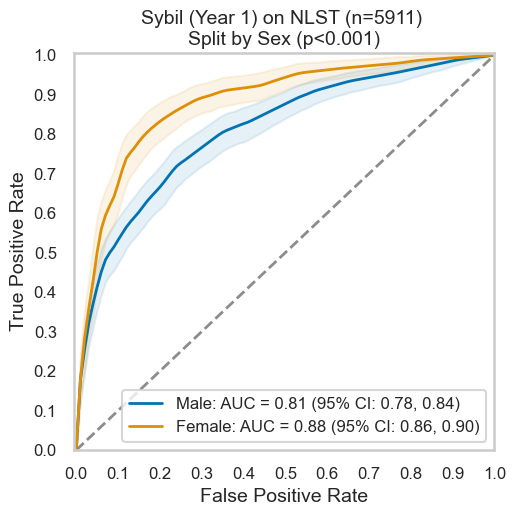

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000363,Male,0.810375,0.783843,0.836403,Female,0.881035,0.856631,0.903728,0.07066


In [104]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Sex', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCgender5911.png")

,num,pct,mal,ben,pct_mal
< 25,1899,32.126544,209,1690,11.005793
≥ 25,4012,67.873456,372,3640,9.272183


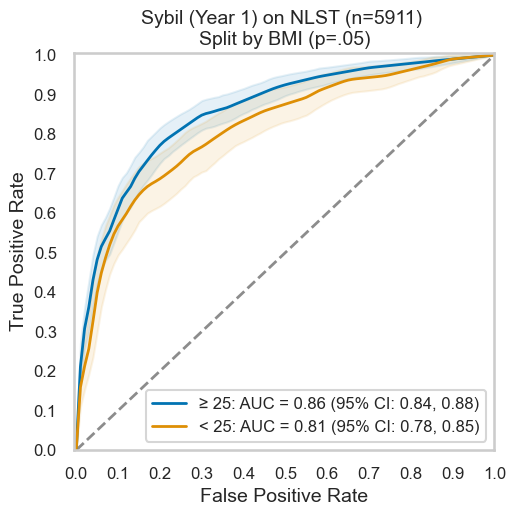

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.051435,≥ 25,0.856063,0.835375,0.87804,< 25,0.814306,0.779593,0.847962,-0.041758


In [105]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'BMI', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilBMIroc5911.png")

,num,pct,mal,ben,pct_mal
False,3755,63.52563,317,3438,8.442077
True,2156,36.47437,264,1892,12.244898


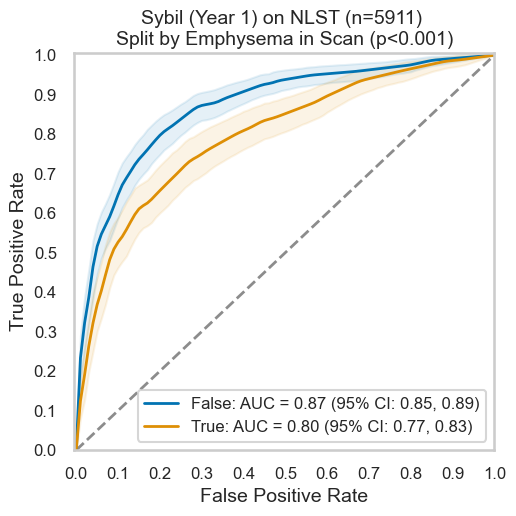

,p,Group_1,AUC_1,AUC-CI-lo_1,AUC-CI-hi_1,Group_2,AUC_2,AUC-CI-lo_2,AUC-CI-hi_2,AUC_diff
Sybil (Year 1),0.000453,False,0.869197,0.847325,0.889735,True,0.79729,0.767805,0.828122,-0.071907


In [106]:
_ = roc.plot_rocs_subgroups(nlst_5911, 'Emphysema in Scan', models={'Sybil (Year 1)': 'sybil_year1'}, two_subgroups=True, dataset_name="NLST", num_bootstraps=1000, imgpath=f"{FIG_DIR}/sybilROCemphysema5911.png")

## Threshold Utilities

In [37]:
dlcst_preds_pretty, _ = data.nlst_pretty_labels(dlcst_preds, DLCST_DEMOCOLS)
threshold_dlcst = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-dlcst-{len(dlcst_preds)}.csv', index_col=0)
threshold_dlcst, dlcst_policies = output.threshold_stats_pretty(threshold_dlcst, dlcst_policies)

In [38]:
threshold_nlst_5911 = pd.read_csv(f'{RESULTS_DIR}/threshold-perfs-nlst-5911.csv', index_col=0)
threshold_nlst_5911, nlst_5911_policies = output.threshold_stats_pretty(threshold_nlst_5911, nlst_5911_policies)

## Threshold Plots

### DLCST

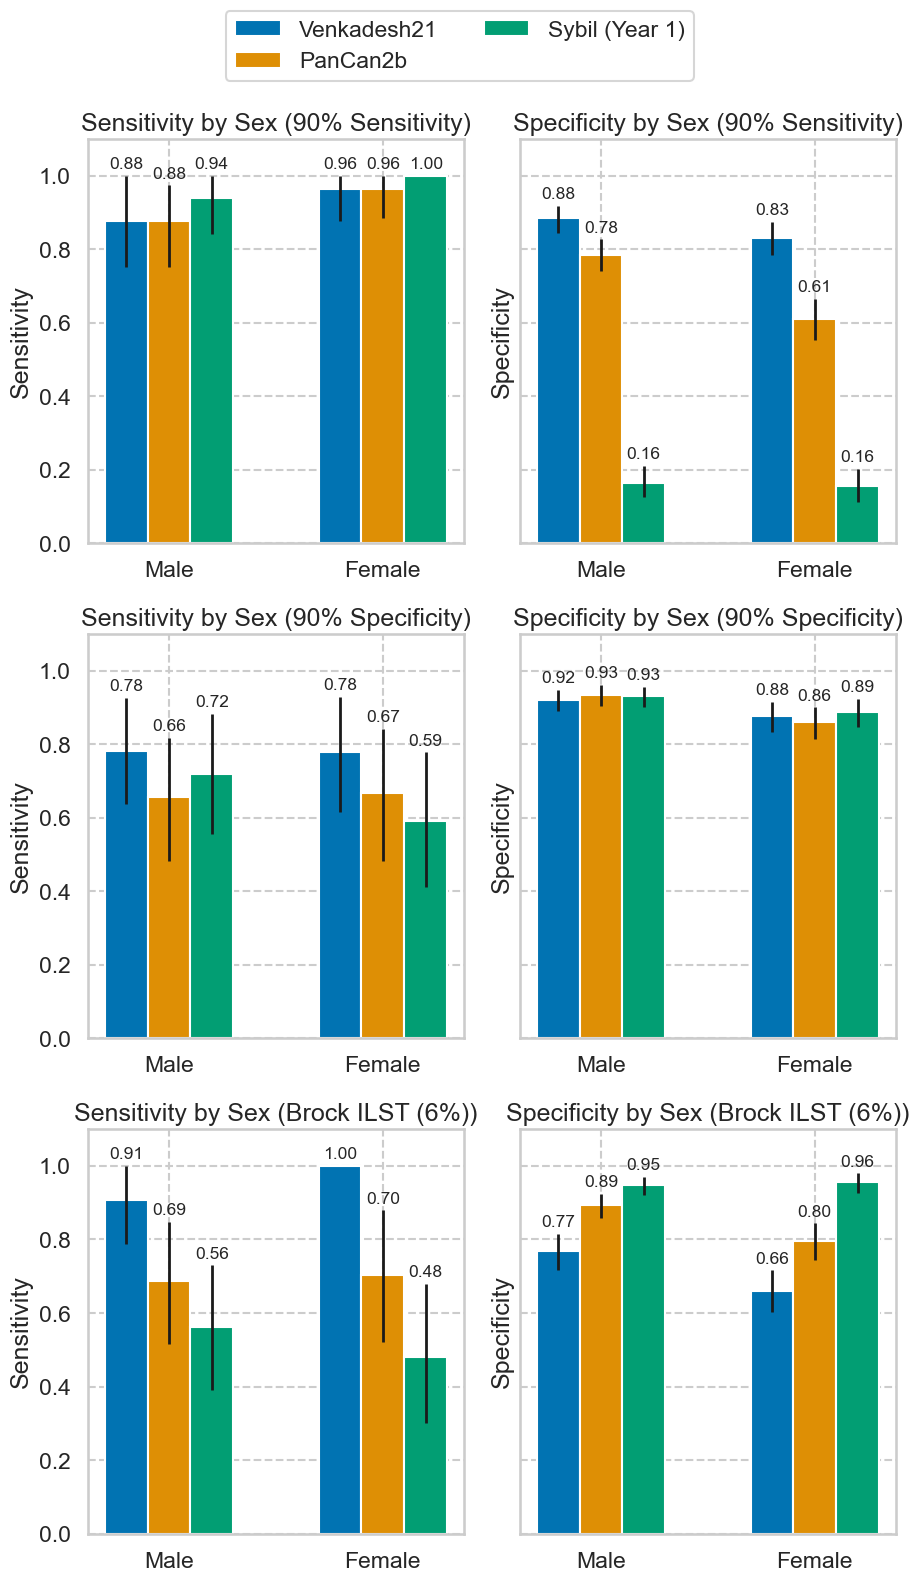

In [107]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Sex', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Sex"'),
                                             plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTsex.png"
                                            )

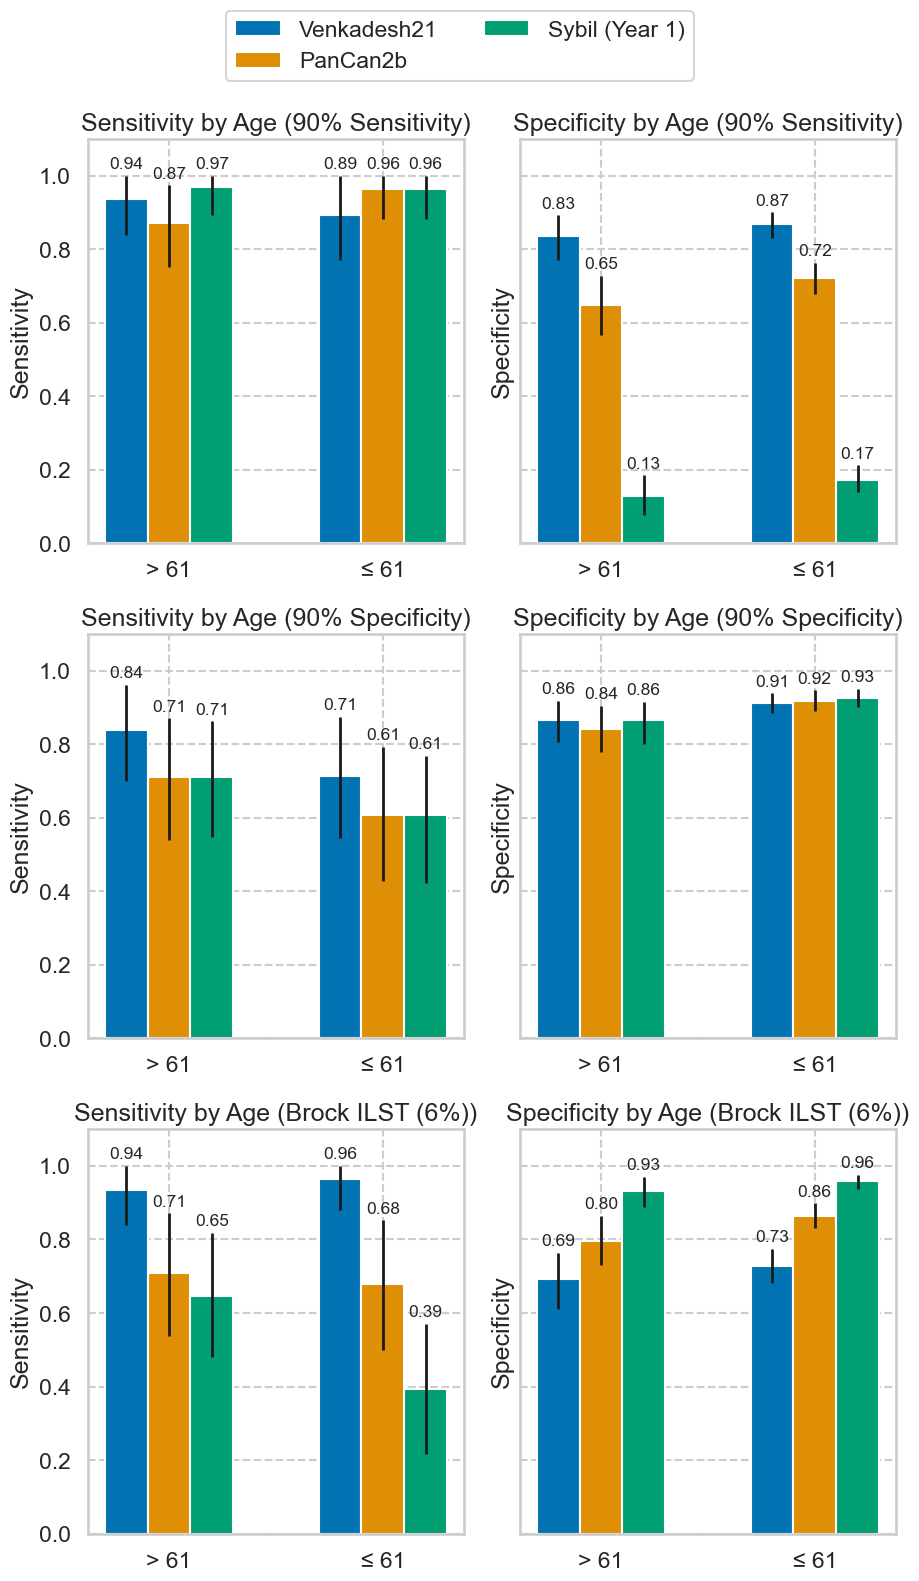

In [40]:
_ = threshold.plot_threshold_stats_subgroups(dlcst_preds_pretty, 'Age', dataset_name='DLCST',
                                             policies=dlcst_policies, models=output.DLCST_MODELCOLS, 
                                             stats=threshold_dlcst.query('attribute == "Age"'),
                                             plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
                                             imgpath=f"{FIG_DIR}/thresholdDLCSTage.png"
                                            )

### NLST 5911


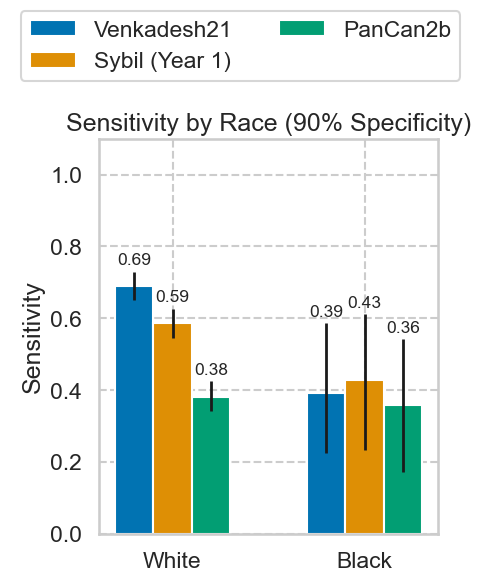

In [41]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Race", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Specificity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Race"'),
                                                plot_metrics=['Sensitivity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTPRrace5911.png"
                                                )  

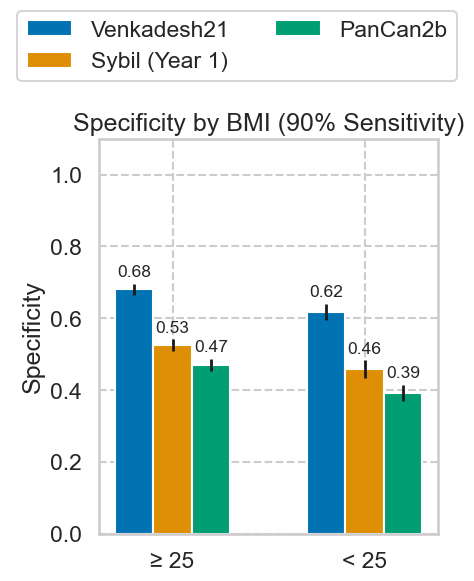

In [42]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "BMI", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "BMI"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRbmi5911.png"
                                                )  

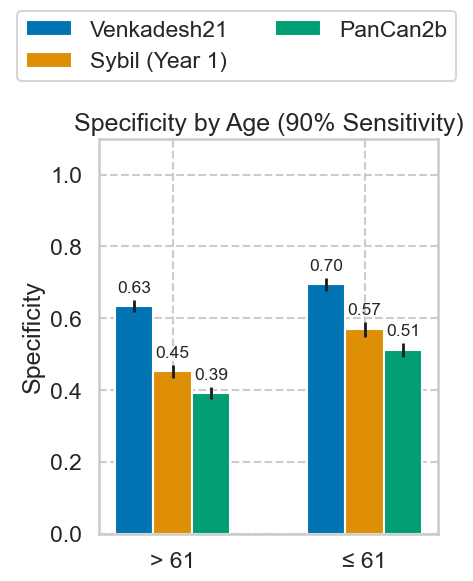

In [43]:
_ = threshold.plot_threshold_stats_subgroups(nlst_5911, "Age", dataset_name='NLST',
                                                policies=nlst_5911_policies[['90% Sensitivity']], models=output.NLST_5911_MODELCOLS, 
                                                stats=threshold_nlst_5911.query(f'attribute == "Age"'),
                                                plot_metrics=['Specificity'], diff=False, show_mb_count=False,
                                                imgpath=f"{FIG_DIR}/allTNRage5911.png"
                                                )  

#### all columns

In [44]:
# print(nlst_demos_to_include)
# for col in nlst_demos_to_include:
#     _ = threshold.plot_threshold_stats_subgroups(nlst_5911, col, dataset_name='NLST',
#                                                 policies=nlst_5911_policies, models=output.NLST_5911_MODELCOLS, 
#                                                 stats=threshold_nlst_5911.query(f'attribute == "{col}"'),
#                                                 plot_metrics=['Sensitivity', 'Specificity'], diff=False, show_mb_count=False,
#                                                 imgpath=f"{FIG_DIR}/threshold-NLST-5911/{col}.png"
#                                                 )  

## Threshold Tables

### DLCST

In [109]:
dlcst_demos_to_include = ['Age', 'Sex']
pairwise_tpr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='Sensitivity')
threshold_tpr_dlcst = output.threshold_results_pretty(pairwise_tpr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='Sensitivity')
tpr_dlcst_demo = threshold_tpr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tpr_dlcst_demo

Venkadesh21              PanCan2b     \
                                        Sensitivity CI        Sensitivity CI   
Policy          Attribute Group                                                
90% Sensitivity Age       > 61    0.94 (0.84, 1.00)     0.87 (0.75, 0.97)      
                          ≤ 61    0.89 (0.77, 1.00)     0.96 (0.88, 1.00)      
                Sex       Male    0.88 (0.75, 1.00)     0.88 (0.75, 0.97)      
                          Female  0.96 (0.88, 1.00)     0.96 (0.88, 1.00)      
90% Specificity Age       > 61    0.84 (0.70, 0.96)     0.71 (0.54, 0.87)      
                          ≤ 61    0.71 (0.55, 0.88)     0.61 (0.43, 0.79)      
                Sex       Male    0.78 (0.64, 0.93)     0.66 (0.48, 0.82)      
                          Female  0.78 (0.62, 0.93)     0.67 (0.48, 0.84)      
Brock ILST (6%) Age       > 61    0.94 (0.84, 1.00)     0.71 (0.54, 0.87)      
                          ≤ 61    0.96 (0.88, 1.00)     0.68 (0.50, 0.85)      
                Sex       Male    0.91 (0.79, 1.00)     0.69 (0.52, 0.85)      
                          Female  1.00 (1.00, 1.00)     0.70 (0.52, 0.88)      

                                     Sybil (Year 1)     
                                        Sensitivity CI  
Policy          Attribute Group                         
90% Sensitivity Age       > 61    0.97 (0.89, 1.00)     
                          ≤ 61    0.96 (0.88, 1.00)     
                Sex       Male    0.94 (0.84, 1.00)     
                          Female  1.00 (1.00, 1.00)     
90% Specificity Age       > 61    0.71 (0.55, 0.86)     
                          ≤ 61    0.61 (0.42, 0.77)     
                Sex       Male    0.72 (0.56, 0.88)     
                          Female  0.59 (0.41, 0.78)     
Brock ILST (6%) Age       > 61    0.65 (0.48, 0.82)     
                          ≤ 61    0.39 (0.22, 0.57)  *  
                Sex       Male    0.56 (0.39, 0.73)     
                          Female  0.48 (0.30, 0.68)

In [110]:
print(tpr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTPR.tex",
    hrules=True, label='tab:resDLCSTdemoTPR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% Confidence Intervals) for models for demographic subgroups on DLCST. Single asterisk (*) = sensitivity of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [111]:
pairwise_tnr_dlcst = threshold.all_attribute_pairwise_comparisons(threshold_dlcst, metric='Specificity')
threshold_tnr_dlcst = output.threshold_results_pretty(pairwise_tnr_dlcst, model_order=list(output.DLCST_MODELCOLS.keys()), metric='Specificity')
tnr_dlcst_demo = threshold_tnr_dlcst.xs("Demographics", level='Category').query('Attribute in @dlcst_demos_to_include & Policy in @POLICIES_TO_USE')
tnr_dlcst_demo

Venkadesh21               PanCan2b  \
                                        Specificity  CI        Specificity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.83 (0.77, 0.89)      0.65 (0.57, 0.73)   
                          ≤ 61    0.87 (0.83, 0.90)      0.72 (0.68, 0.76)   
                Sex       Male    0.88 (0.84, 0.92)      0.78 (0.74, 0.83)   
                          Female  0.83 (0.78, 0.87)   *  0.61 (0.55, 0.66)   
90% Specificity Age       > 61    0.86 (0.81, 0.92)      0.84 (0.78, 0.90)   
                          ≤ 61    0.91 (0.88, 0.94)      0.92 (0.89, 0.95)   
                Sex       Male    0.92 (0.89, 0.95)      0.93 (0.90, 0.96)   
                          Female  0.88 (0.83, 0.91)   *  0.86 (0.81, 0.90)   
Brock ILST (6%) Age       > 61    0.69 (0.61, 0.76)      0.80 (0.73, 0.86)   
                          ≤ 61    0.73 (0.68, 0.78)      0.86 (0.83, 0.90)   
                Sex       Male    0.77 (0.72, 0.82)      0.89 (0.86, 0.92)   
                          Female  0.66 (0.60, 0.72)  **  0.80 (0.74, 0.84)   

                                         Sybil (Year 1)     
                                  CI        Specificity CI  
Policy          Attribute Group                             
90% Sensitivity Age       > 61        0.13 (0.08, 0.18)     
                          ≤ 61        0.17 (0.14, 0.21)     
                Sex       Male        0.16 (0.13, 0.21)     
                          Female  **  0.16 (0.11, 0.20)     
90% Specificity Age       > 61        0.86 (0.80, 0.92)     
                          ≤ 61     *  0.93 (0.90, 0.95)  *  
                Sex       Male        0.93 (0.90, 0.96)     
                          Female  **  0.89 (0.85, 0.92)  *  
Brock ILST (6%) Age       > 61        0.93 (0.89, 0.97)     
                          ≤ 61     *  0.96 (0.94, 0.98)     
                Sex       Male        0.95 (0.92, 0.97)     
                          Female  **  0.96 (0.93, 0.98)

In [112]:
print(tnr_dlcst_demo.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resDLCSTdemoTNR.tex",
    hrules=True, label='tab:resDLCSTdemoTNR', environment='table*', column_format=f'lll{"|ll"*len(dlcst_model_order)}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% Confidence Intervals) for models for demographic subgroups on DLCST. Single asterisk (*) = specificity of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### NLST 5911

In [113]:
pairwise_tpr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric='Sensitivity')
threshold_tpr = output.threshold_results_pretty(pairwise_tpr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='Sensitivity')
tpr_demo_5911 = threshold_tpr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tpr_demo_5911

Venkadesh21         Sybil (Year 1)  \
                                        Sensitivity  CI        Sensitivity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.90 (0.86, 0.93)      0.91 (0.88, 0.94)   
                          ≤ 61    0.91 (0.87, 0.94)      0.90 (0.86, 0.94)   
                BMI       ≥ 25    0.90 (0.87, 0.93)      0.92 (0.89, 0.95)   
                          < 25    0.90 (0.86, 0.94)      0.89 (0.84, 0.93)   
                Height    ≤ 68    0.90 (0.87, 0.94)      0.92 (0.89, 0.95)   
                          > 68    0.90 (0.85, 0.93)      0.89 (0.85, 0.92)   
                Race      White   0.90 (0.88, 0.93)      0.91 (0.89, 0.93)   
                          Black   0.82 (0.67, 0.96)      0.86 (0.71, 0.97)   
                Sex       Male    0.90 (0.87, 0.93)      0.90 (0.86, 0.93)   
                          Female  0.90 (0.86, 0.93)      0.92 (0.89, 0.95)   
                Weight    ≤ 180   0.91 (0.87, 0.94)      0.92 (0.89, 0.94)   
                          > 180   0.89 (0.85, 0.93)      0.89 (0.85, 0.93)   
90% Specificity Age       > 61    0.70 (0.66, 0.75)      0.61 (0.56, 0.66)   
                          ≤ 61    0.65 (0.58, 0.71)      0.53 (0.47, 0.60)   
                BMI       ≥ 25    0.68 (0.63, 0.72)      0.58 (0.53, 0.63)   
                          < 25    0.69 (0.62, 0.75)      0.59 (0.52, 0.65)   
                Height    ≤ 68    0.70 (0.65, 0.75)      0.63 (0.58, 0.68)   
                          > 68    0.66 (0.61, 0.72)      0.52 (0.47, 0.58)   
                Race      White   0.69 (0.65, 0.73)      0.59 (0.54, 0.63)   
                          Black   0.39 (0.23, 0.59)  **  0.43 (0.23, 0.61)   
                Sex       Male    0.66 (0.61, 0.71)      0.53 (0.48, 0.58)   
                          Female  0.71 (0.65, 0.77)      0.66 (0.60, 0.71)   
                Weight    ≤ 180   0.69 (0.64, 0.73)      0.59 (0.54, 0.65)   
                          > 180   0.68 (0.62, 0.73)      0.57 (0.51, 0.63)   
Brock ILST (6%) Age       > 61    0.88 (0.84, 0.91)      0.61 (0.56, 0.66)   
                          ≤ 61    0.89 (0.85, 0.93)      0.53 (0.47, 0.60)   
                BMI       ≥ 25    0.89 (0.86, 0.92)      0.58 (0.53, 0.63)   
                          < 25    0.88 (0.83, 0.92)      0.59 (0.52, 0.65)   
                Height    ≤ 68    0.89 (0.85, 0.92)      0.63 (0.58, 0.68)   
                          > 68    0.88 (0.84, 0.91)      0.52 (0.47, 0.58)   
                Race      White   0.89 (0.86, 0.91)      0.59 (0.54, 0.63)   
                          Black   0.75 (0.59, 0.91)      0.43 (0.23, 0.61)   
                Sex       Male    0.88 (0.85, 0.91)      0.53 (0.48, 0.58)   
                          Female  0.89 (0.85, 0.92)      0.66 (0.60, 0.71)   
                Weight    ≤ 180   0.88 (0.84, 0.91)      0.59 (0.54, 0.65)   
                          > 180   0.89 (0.85, 0.93)      0.57 (0.51, 0.63)   

                                               PanCan2b      
                                  CI        Sensitivity  CI  
Policy          Attribute Group                              
90% Sensitivity Age       > 61        0.92 (0.89, 0.95)      
                          ≤ 61        0.87 (0.81, 0.91)   *  
                BMI       ≥ 25        0.91 (0.88, 0.94)      
                          < 25        0.88 (0.84, 0.92)      
                Height    ≤ 68        0.92 (0.89, 0.95)      
                          > 68        0.88 (0.84, 0.91)   *  
                Race      White       0.90 (0.87, 0.92)      
                          Black       0.89 (0.77, 1.00)      
                Sex       Male        0.88 (0.85, 0.92)      
                          Female      0.92 (0.89, 0.95)   *  
                Weight    ≤ 180       0.91 (0.88, 0.94)      
                          > 180       0.89 (0.84, 0.92)      
90% Specificity Age       > 61        0.40 (0.34, 0.45)      
     

In [114]:
print(tpr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTPR.tex",
    hrules=True, label='tab:resNLSTfullTPR', environment='table*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Sensitivity (with 95\% Confidence Intervals) for models for demographic subgroups on NLST. Single asterisk (*) = sensitivity of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [115]:
pairwise_tnr_5911 = threshold.all_attribute_pairwise_comparisons(threshold_nlst_5911, metric='Specificity')
threshold_tnr = output.threshold_results_pretty(pairwise_tnr_5911, model_order=list(output.NLST_5911_MODELCOLS.keys()), metric='Specificity')
tnr_demo_5911 = threshold_tnr.xs("Demographics", level='Category').query('Attribute in @nlst_demos_to_include & Policy in @POLICIES_TO_USE & Attribute not in @invalid_attributes_5911')
tnr_demo_5911

Venkadesh21         Sybil (Year 1)  \
                                        Specificity  CI        Specificity   
Policy          Attribute Group                                              
90% Sensitivity Age       > 61    0.63 (0.62, 0.65)      0.45 (0.43, 0.47)   
                          ≤ 61    0.70 (0.68, 0.71)  **  0.57 (0.55, 0.59)   
                BMI       ≥ 25    0.68 (0.67, 0.70)      0.53 (0.51, 0.54)   
                          < 25    0.62 (0.59, 0.64)  **  0.46 (0.43, 0.48)   
                Height    ≤ 68    0.68 (0.66, 0.69)      0.55 (0.53, 0.57)   
                          > 68    0.64 (0.63, 0.66)   *  0.45 (0.43, 0.47)   
                Race      White   0.66 (0.65, 0.67)      0.50 (0.49, 0.51)   
                          Black   0.73 (0.66, 0.79)   *  0.59 (0.52, 0.67)   
                Sex       Male    0.65 (0.63, 0.66)      0.46 (0.44, 0.48)   
                          Female  0.68 (0.66, 0.70)   *  0.56 (0.54, 0.58)   
                Weight    ≤ 180   0.65 (0.63, 0.67)      0.49 (0.48, 0.51)   
                          > 180   0.67 (0.66, 0.69)   *  0.51 (0.49, 0.53)   
90% Specificity Age       > 61    0.88 (0.87, 0.89)      0.89 (0.88, 0.90)   
                          ≤ 61    0.92 (0.91, 0.93)  **  0.92 (0.91, 0.93)   
                BMI       ≥ 25    0.91 (0.90, 0.92)      0.91 (0.90, 0.92)   
                          < 25    0.87 (0.86, 0.89)  **  0.89 (0.87, 0.90)   
                Height    ≤ 68    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          > 68    0.90 (0.89, 0.91)      0.90 (0.89, 0.92)   
                Race      White   0.90 (0.89, 0.91)      0.90 (0.90, 0.91)   
                          Black   0.93 (0.89, 0.97)      0.92 (0.87, 0.96)   
                Sex       Male    0.90 (0.89, 0.91)      0.90 (0.89, 0.91)   
                          Female  0.90 (0.88, 0.91)      0.90 (0.89, 0.92)   
                Weight    ≤ 180   0.89 (0.88, 0.90)      0.89 (0.88, 0.91)   
                          > 180   0.91 (0.90, 0.92)  **  0.91 (0.90, 0.93)   
Brock ILST (6%) Age       > 61    0.67 (0.65, 0.69)      0.89 (0.88, 0.90)   
                          ≤ 61    0.73 (0.71, 0.75)  **  0.92 (0.91, 0.93)   
                BMI       ≥ 25    0.72 (0.70, 0.73)      0.91 (0.90, 0.92)   
                          < 25    0.66 (0.63, 0.68)  **  0.89 (0.87, 0.90)   
                Height    ≤ 68    0.71 (0.70, 0.73)      0.90 (0.89, 0.91)   
                          > 68    0.68 (0.66, 0.70)  **  0.90 (0.89, 0.92)   
                Race      White   0.70 (0.68, 0.71)      0.90 (0.90, 0.91)   
                          Black   0.76 (0.69, 0.82)      0.92 (0.87, 0.96)   
                Sex       Male    0.68 (0.66, 0.70)      0.90 (0.89, 0.91)   
                          Female  0.72 (0.70, 0.74)  **  0.90 (0.89, 0.92)   
                Weight    ≤ 180   0.69 (0.67, 0.70)      0.89 (0.88, 0.91)   
                          > 180   0.71 (0.69, 0.73)   *  0.91 (0.90, 0.93)   

                                               PanCan2b      
                                  CI        Specificity  CI  
Policy          Attribute Group                              
90% Sensitivity Age       > 61        0.39 (0.38, 0.41)      
                          ≤ 61    **  0.51 (0.49, 0.53)  **  
                BMI       ≥ 25        0.47 (0.45, 0.49)      
                          < 25    **  0.39 (0.37, 0.41)  **  
                Height    ≤ 68        0.41 (0.40, 0.43)      
                          > 68    **  0.48 (0.46, 0.50)  **  
                Race      White       0.45 (0.43, 0.46)      
                          Black   **  0.37 (0.30, 0.45)      
                Sex       Male        0.50 (0.48, 0.52)      
                          Female  **  0.37 (0.35, 0.39)  **  
                Weight    ≤ 180       0.40 (0.39, 0.42)      
                          > 180    *  0.49 (0.47, 0.51)  **  
90% Specificity Age       > 61        0.88 (0.86, 0.89)      
     

In [116]:
print(tnr_demo_5911.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/resNLSTfullTNR.tex",
    hrules=True, label='tab:resNLSTfullTNR', environment='table*', column_format=f'lll{"|ll"*len(list(output.NLST_5911_MODELCOLS.keys()))}', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption='Specificity (with 95\% Confidence Intervals) for models for demographic subgroups on NLST. Single asterisk (*) = specificity of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


# Confounder Results

## Prevalence + ROC Tables

In [117]:
nlst_5911_v2, _, _ = data.prep_nlst_preds(nlst_preds_nodule, nlst_democols_og, scanlevel=True, sybil=True, pretty=False, bin_num=True)

### Sex

In [118]:
gender_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-gender-by-factors-nlst-5911.csv', index_col=0)
gender_prev_roc, gender_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Gender',
    NLST_POSSIBLE_CONFOUNDERS,
    gender_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(gender_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderIsolationPlusROC.tex",
    hrules=True, label='tab:genderIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between sexes, and the AUROC scores of the Sybil (Year 1) model between men and women, isolating for them.'))

gender_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:526: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Male                                  Female        \
                           Mal   Ben Total %              AUROC    Mal   Ben   
Confounder         Subset                                                      
Height             > 68    257  2364    76.2  0.80 (0.77, 0.83)     10   136   
                   ≤ 68     80   740    23.8  0.84 (0.79, 0.88)    234  2090   
Weight             > 180   211  2015    64.7  0.83 (0.80, 0.86)     36   554   
                   ≤ 180   126  1089    35.3  0.77 (0.72, 0.82)    208  1672   
Smoked Pipe        False   197  1967    62.9  0.82 (0.79, 0.85)    239  2172   
                   True    138  1118    36.5  0.80 (0.76, 0.84)      5    40   
Smoked Cigars      False   233  2127    68.6  0.82 (0.79, 0.86)    237  2141   
                   True    102   963    31.0  0.79 (0.74, 0.83)      7    76   
Work w/o Mask      False   228  2029    65.6  0.82 (0.79, 0.85)    214  1936   
                   True    109  1075    34.4  0.79 (0.74, 0.84)     30   290   
Pack-Years         ≤ 55    141  1601    50.6  0.81 (0.77, 0.85)    144  1504   
                   > 55    196  1503    49.4  0.80 (0.77, 0.84)    100   722   
BMI                < 25     92   811    26.2  0.76 (0.70, 0.82)    117   879   
                   ≥ 25    245  2293    73.8  0.83 (0.80, 0.86)    127  1347   
Cigarettes per Day ≤ 25    141  1473    46.9  0.80 (0.76, 0.84)    139  1366   
                   > 25    196  1631    53.1  0.82 (0.78, 0.85)    105   860   
Lived w/ Smoker    False    43   498    15.7  0.81 (0.74, 0.89)     21   103   
                   True    292  2585    83.6  0.81 (0.78, 0.84)    222  2112   
Pneumonia Diag.    True     55   597    18.9  0.68 (0.59, 0.77)     81   649   
                   False   281  2502    80.9  0.84 (0.81, 0.86)    157  1574   

                                                           p  
                          Total %              AUROC          
Confounder         Subset                                     
Height             > 68       5.9  0.84 (0.69, 0.96)     .63  
                   ≤ 68      94.1  0.88 (0.86, 0.90)     .17  
Weight             > 180     23.9  0.86 (0.77, 0.93)     .44  
                   ≤ 180     76.1  0.88 (0.86, 0.90)  < .001  
Smoked Pipe        False     97.6  0.88 (0.85, 0.90)     .01  
                   True       1.8  0.97 (0.93, 1.00)    .002  
Smoked Cigars      False     96.3  0.88 (0.85, 0.90)     .01  
                   True       3.4  0.97 (0.92, 1.00)    .001  
Work w/o Mask      False     87.0  0.89 (0.87, 0.91)  < .001  
                   True      13.0  0.79 (0.69, 0.87)     .92  
Pack-Years         ≤ 55      66.7  0.87 (0.83, 0.90)     .06  
                   > 55      33.3  0.90 (0.86, 0.93)  < .001  
BMI                < 25      40.3  0.85 (0.81, 0.89)    .009  
                   ≥ 25      59.7  0.90 (0.87, 0.93)    .003  
Cigarettes per Day ≤ 25      60.9  0.86 (0.82, 0.89)     .06  
                   > 25      39.1  0.91 (0.88, 0.94)  < .001  
Lived w/ Smoker    False      5.0  0.85 (0.75, 0.93)     .63  
                   True      94.5  0.88 (0.86, 0.91)  < .001  
Pneumonia Diag.    True      29.6  0.86 (0.81, 0.90)  < .001  
                   False     70.1  0.90 (0.87, 0.92)    .007

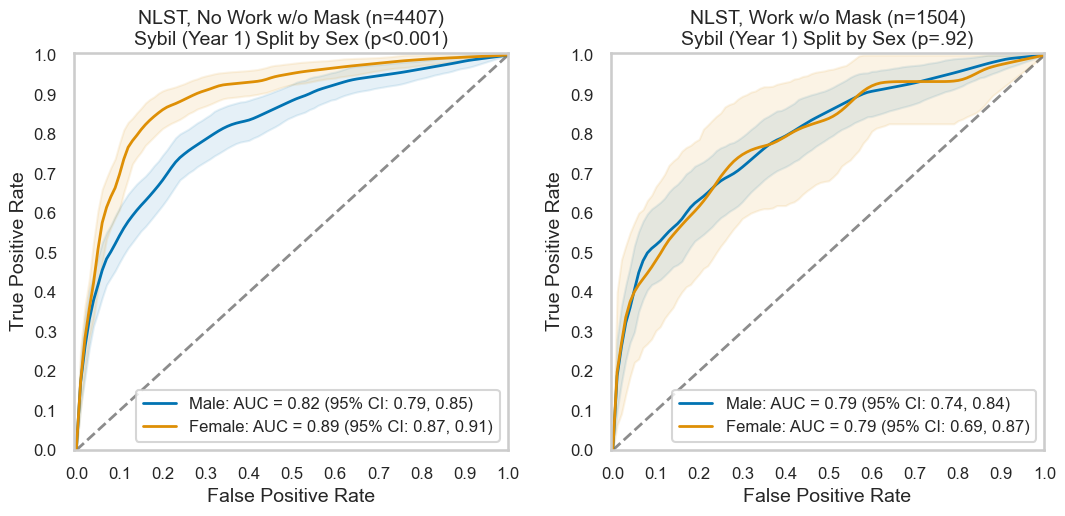

In [119]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Sex',
    'Work w/o Mask',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCgender-WrkNoMask.png"
)

### Race

In [120]:
cat_race_confounders, num_race_confounders = output.confounders_by_attribute(nlst_5911_v2, 'WhiteOrBlack', NLST_POSSIBLE_CONFOUNDERS, precision=1)
num_race_confounders

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]


White Mal     White Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       64.1 (5.2)    63.1 (5.3)   
                                    Median (IQR)        64 (8)        62 (8)   
             Body Mass Index        Mean (SD)       26.9 (4.4)    27.6 (4.9)   
                                    Median (IQR)        26 (4)        27 (6)   
             Height                 Mean (SD)       68.0 (3.9)    68.0 (4.0)   
                                    Median (IQR)        68 (6)        68 (6)   
             Weight                 Mean (SD)     177.4 (36.6)  182.7 (39.1)   
                                    Median (IQR)      176 (50)      180 (51)   
Other        Diameter (mm)          Mean (SD)       14.4 (9.4)     8.4 (5.1)   
                                    Median (IQR)        12 (8)         6 (4)   
             Nodules Per Scan       Mean (SD)        2.3 (1.3)     1.9 (1.2)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       16.2 (3.5)    16.5 (3.5)   
                                    Median (IQR)        16 (4)        16 (3)   
             Cigarettes per Day     Mean (SD)      30.9 (12.9)   28.6 (11.5)   
                                    Median (IQR)       30 (20)       25 (15)   
             Pack-Years             Mean (SD)      66.8 (30.2)   57.7 (24.2)   
                                    Median (IQR)       57 (39)       51 (29)   
             Total Years of Smoking Mean (SD)       43.5 (7.2)    40.9 (7.4)   
                                    Median (IQR)       44 (10)       41 (10)   

                                                     Black Mal     Black Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       63.0 (4.0)    62.6 (5.1)   
                                    Median (IQR)        63 (7)        62 (8)   
             Body Mass Index        Mean (SD)       27.2 (3.8)    28.5 (6.0)   
                                    Median (IQR)        25 (5)        28 (6)   
             Height                 Mean (SD)       67.0 (4.4)    67.7 (3.9)   
                                    Median (IQR)        66 (7)        67 (7)   
             Weight                 Mean (SD)     173.5 (30.2)  185.5 (42.8)   
                                    Median (IQR)      165 (39)      183 (47)   
Other        Diameter (mm)          Mean (SD)      14.7 (10.4)     9.0 (5.5)   
                                    Median (IQR)       12 (10)         6 (5)   
             Nodules Per Scan       Mean (SD)        2.2 (1.1)     1.7 (1.1)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       17.7 (3.4)    17.1 (3.5)   
                                    Median (IQR)        17 (4)        17 (4)   
             Cigarettes per Day     Mean (SD)       23.9 (7.7)    23.0 (8.0)   
                                    Median (IQR)       20 (10)        20 (4)   
             Pack-Years             Mean (SD)      51.2 (19.2)   48.1 (18.5)   
                                    Median (IQR)       48 (16)       42 (18)   
             Total Years of Smoking Mean (SD)       42.7 (5.7)    42.0 (6.8)   
                                    Median (IQR)       43 (11)        42 (9)   

                                                  Difference  
Category     Confounder             Subset                    
Demographics Age                    Mean (SD)         0.5507  
                                    Median (IQR)     -0.5000  
             Body Mass Index        Mean (SD)        -0.7176  
                                    Median (IQR)     -0.7401  
             Height                 Mean (SD)         0.4392  
                                    Median (IQR)      1.0000  
             Weight        

In [121]:
num_race_confounders

White Mal     White Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       64.1 (5.2)    63.1 (5.3)   
                                    Median (IQR)        64 (8)        62 (8)   
             Body Mass Index        Mean (SD)       26.9 (4.4)    27.6 (4.9)   
                                    Median (IQR)        26 (4)        27 (6)   
             Height                 Mean (SD)       68.0 (3.9)    68.0 (4.0)   
                                    Median (IQR)        68 (6)        68 (6)   
             Weight                 Mean (SD)     177.4 (36.6)  182.7 (39.1)   
                                    Median (IQR)      176 (50)      180 (51)   
Other        Diameter (mm)          Mean (SD)       14.4 (9.4)     8.4 (5.1)   
                                    Median (IQR)        12 (8)         6 (4)   
             Nodules Per Scan       Mean (SD)        2.3 (1.3)     1.9 (1.2)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       16.2 (3.5)    16.5 (3.5)   
                                    Median (IQR)        16 (4)        16 (3)   
             Cigarettes per Day     Mean (SD)      30.9 (12.9)   28.6 (11.5)   
                                    Median (IQR)       30 (20)       25 (15)   
             Pack-Years             Mean (SD)      66.8 (30.2)   57.7 (24.2)   
                                    Median (IQR)       57 (39)       51 (29)   
             Total Years of Smoking Mean (SD)       43.5 (7.2)    40.9 (7.4)   
                                    Median (IQR)       44 (10)       41 (10)   

                                                     Black Mal     Black Ben  \
Category     Confounder             Subset                                     
Demographics Age                    Mean (SD)       63.0 (4.0)    62.6 (5.1)   
                                    Median (IQR)        63 (7)        62 (8)   
             Body Mass Index        Mean (SD)       27.2 (3.8)    28.5 (6.0)   
                                    Median (IQR)        25 (5)        28 (6)   
             Height                 Mean (SD)       67.0 (4.4)    67.7 (3.9)   
                                    Median (IQR)        66 (7)        67 (7)   
             Weight                 Mean (SD)     173.5 (30.2)  185.5 (42.8)   
                                    Median (IQR)      165 (39)      183 (47)   
Other        Diameter (mm)          Mean (SD)      14.7 (10.4)     9.0 (5.5)   
                                    Median (IQR)       12 (10)         6 (5)   
             Nodules Per Scan       Mean (SD)        2.2 (1.1)     1.7 (1.1)   
                                    Median (IQR)         2 (2)         1 (1)   
Smoking      Age at Smoking Onset   Mean (SD)       17.7 (3.4)    17.1 (3.5)   
                                    Median (IQR)        17 (4)        17 (4)   
             Cigarettes per Day     Mean (SD)       23.9 (7.7)    23.0 (8.0)   
                                    Median (IQR)       20 (10)        20 (4)   
             Pack-Years             Mean (SD)      51.2 (19.2)   48.1 (18.5)   
                                    Median (IQR)       48 (16)       42 (18)   
             Total Years of Smoking Mean (SD)       42.7 (5.7)    42.0 (6.8)   
                                    Median (IQR)       43 (11)        42 (9)   

                                                  Difference  
Category     Confounder             Subset                    
Demographics Age                    Mean (SD)         0.5507  
                                    Median (IQR)     -0.5000  
             Body Mass Index        Mean (SD)        -0.7176  
                                    Median (IQR)     -0.7401  
             Height                 Mean (SD)         0.4392  
                                    Median (IQR)      1.0000  
             Weight        

In [122]:
nlst_preds_nodule.groupby(['WhiteOrBlack'])[['NoduleType', 'label']].value_counts(dropna=True, normalize=True)

WhiteOrBlack  NoduleType          label
1.0           Solid               0        0.555186
              GroundGlassOpacity  0        0.220346
              SemiSolid           0        0.089362
              Perifissural        0        0.058444
              Solid               1        0.052859
              PartSolid           1        0.015160
              NonSolid            1        0.008112
              Calcified           0        0.000532
2.0           Solid               0        0.471933
              GroundGlassOpacity  0        0.255717
              SemiSolid           0        0.116424
              Solid               1        0.101871
              Perifissural        0        0.037422
              PartSolid           1        0.010395
              NonSolid            1        0.006237
Name: proportion, dtype: float64

In [123]:
nlst_5911_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5911 entries, 0 to 10182
Columns: 130 entries, PatientID to NoduleCounts > 1
dtypes: bool(36), float64(82), int64(11), object(1)
memory usage: 4.5+ MB


In [124]:
cat_race_confounders.xs("Nodule")

White               Black              Difference  \
                              Mal   Ben Total %   Mal  Ben Total %              
Confounder           Subset                                                     
Calcified Nodule     False    530  4988    99.9    28  160   100.0    -0.0905   
                     True       0     5     0.1     0    0     0.0     0.0905   
Ground-Glass Nodule  False    530  3483    72.7    28  100    68.1     4.5747   
                     True       0  1510    27.3     0   60    31.9    -4.5747   
Nodule in Upper Lung False    206  2461    48.3    13   77    47.9     0.4167   
                     True     324  2532    51.7    15   83    52.1    -0.4167   
Non-Solid Nodule     False    480  4993    99.1    26  160    98.9     0.1585   
                     True      50     0     0.9     2    0     1.1    -0.1585   
Part-Solid Nodule    False    437  4993    98.3    24  160    97.9     0.4438   
                     True      93     0     1.7     4    0     2.1    -0.4438   
Perfissural Nodule   False    530  4495    91.0    28  145    92.0    -1.0381   
                     True       0   498     9.0     0   15     8.0     1.0381   
Semi-Solid Nodule    False    530  4303    87.5    28  131    84.6     2.9323   
                     True       0   690    12.5     0   29    15.4    -2.9323   
Solid Nodule         False    133  1614    31.6     5   69    39.4    -7.7303   
                     True     397  3379    68.4    23   91    60.6     7.7303   
Spiculated Nodule    False    520  4992    99.8    28  160   100.0    -0.1992   
                     True      10     1     0.2     0    0     0.0     0.1992   

                            Abs Diff  
                                      
Confounder           Subset           
Calcified Nodule     False    0.0905  
                     True     0.0905  
Ground-Glass Nodule  False    4.5747  
                     True     4.5747  
Nodule in Upper Lung False    0.4167  
                     True     0.4167  
Non-Solid Nodule     False    0.1585  
                     True     0.1585  
Part-Solid Nodule    False    0.4438  
                     True     0.4438  
Perfissural Nodule   False    1.0381  
                     True     1.0381  
Semi-Solid Nodule    False    2.9323  
                     True     2.9323  
Solid Nodule         False    7.7303  
                     True     7.7303  
Spiculated Nodule    False    0.1992  
                     True     0.1992

In [125]:
race_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-race-by-factors-nlst-5911.csv', index_col=0)
race_prev_roc, race_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'WhiteOrBlack',
    NLST_POSSIBLE_CONFOUNDERS,
    race_roc,
    'Venkadesh21',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(race_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceIsolationPlusROC.tex",
    hrules=True, label='tab:raceIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between White and Black participants, and the AUROC scores of the Venkadesh21 model between these racial groups isolating for them.'))

race_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:526: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

White                                  Black       \
                              Mal   Ben Total %              AUROC   Mal  Ben   
Confounder           Subset                                                     
Cigarettes per Day   ≤ 25     246  2610    51.7  0.88 (0.86, 0.90)    20  127   
                     > 25     284  2383    48.3  0.90 (0.89, 0.92)     8   33   
Pack-Years           > 55     281  2116    43.4  0.90 (0.88, 0.91)     5   35   
                     ≤ 55     249  2877    56.6  0.88 (0.86, 0.90)    23  125   
Hypertension Diag.   True     196  1617    32.8  0.87 (0.84, 0.90)    16   86   
                     False    329  3373    67.0  0.90 (0.89, 0.92)    12   74   
Current Smoker       False    247  2542    50.5  0.89 (0.87, 0.91)    11   48   
                     True     283  2451    49.5  0.89 (0.87, 0.91)    17  112   
Smoked Pipe          True     132  1127    22.8  0.90 (0.87, 0.92)     5   12   
                     False    397  3837    76.7  0.89 (0.87, 0.91)    23  145   
Sex                  Female   218  2084    41.7  0.89 (0.87, 0.91)    15   88   
                     Male     312  2909    58.3  0.89 (0.87, 0.91)    13   72   
Diabetes Diag.       True      50   412     8.4  0.90 (0.86, 0.94)     4   31   
                     False    480  4578    91.6  0.89 (0.88, 0.90)    24  129   
Height               > 68     248  2389    47.7  0.89 (0.87, 0.91)    11   60   
                     ≤ 68     282  2604    52.3  0.89 (0.87, 0.91)    17  100   
Work - Farming       True      45   635    12.3  0.90 (0.85, 0.94)     2    4   
                     False    485  4358    87.7  0.89 (0.88, 0.91)    26  156   
Age at Smoking Onset > 16     210  2258    44.7  0.90 (0.87, 0.92)    18   81   
                     ≤ 16     320  2735    55.3  0.89 (0.87, 0.91)    10   79   

                                                          p  
                            Total %              AUROC       
Confounder           Subset                                  
Cigarettes per Day   ≤ 25      78.2  0.77 (0.67, 0.87)  .08  
                     > 25      21.8  0.94 (0.85, 1.00)  .50  
Pack-Years           > 55      21.3  0.93 (0.83, 1.00)  .63  
                     ≤ 55      78.7  0.79 (0.69, 0.88)  .10  
Hypertension Diag.   True      54.3  0.73 (0.61, 0.85)  .04  
                     False     45.7  0.93 (0.87, 0.98)  .60  
Current Smoker       False     31.4  0.88 (0.77, 0.96)  .80  
                     True      68.6  0.76 (0.62, 0.88)  .05  
Smoked Pipe          True       9.0  0.93 (0.77, 1.00)  .75  
                     False     89.4  0.80 (0.70, 0.89)  .11  
Sex                  Female    54.8  0.84 (0.75, 0.92)  .40  
                     Male      45.2  0.81 (0.66, 0.93)  .24  
Diabetes Diag.       True      18.6  0.67 (0.32, 1.00)  .11  
                     False     81.4  0.83 (0.74, 0.91)  .26  
Height               > 68      37.8  0.78 (0.61, 0.93)  .19  
                     ≤ 68      62.2  0.84 (0.76, 0.92)  .36  
Work - Farming       True       3.2  0.99 (1.00, 1.00)  .05  
                     False     96.8  0.81 (0.71, 0.88)  .09  
Age at Smoking Onset > 16      52.7  0.78 (0.66, 0.89)  .07  
                     ≤ 16      47.3  0.88 (0.80, 0.95)  .90

In [126]:
race_roc_all = output.roc_isolations_pretty(
        race_roc, 'WhiteOrBlack', 'Venkadesh21', precision=2
)

c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_2_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [127]:
race_roc_all.xs('Nodule')

White              Black    p
                                         AUROC              AUROC     
Confounder           Subset                                           
Solid Nodule         False   0.88 (0.84, 0.91)  0.60 (0.30, 0.89)  .03
                     True    0.90 (0.88, 0.91)  0.87 (0.80, 0.94)  .62
Ground-Glass Nodule  False   0.89 (0.87, 0.90)  0.82 (0.73, 0.90)  .16
Perfissural Nodule   False   0.89 (0.87, 0.90)  0.81 (0.72, 0.88)  .09
Non-Solid Nodule     False   0.90 (0.89, 0.92)  0.86 (0.79, 0.91)  .35
Part-Solid Nodule    False   0.89 (0.87, 0.90)  0.82 (0.74, 0.90)  .24
Semi-Solid Nodule    False   0.91 (0.89, 0.92)  0.86 (0.78, 0.93)  .31
Calcified Nodule     False   0.89 (0.88, 0.91)  0.82 (0.74, 0.89)  .14
Nodule in Upper Lung False   0.93 (0.92, 0.95)  0.91 (0.79, 0.98)  .65
                     True    0.85 (0.83, 0.87)  0.70 (0.56, 0.82)  .03
Spiculated Nodule    False   0.89 (0.88, 0.90)  0.82 (0.74, 0.89)  .15

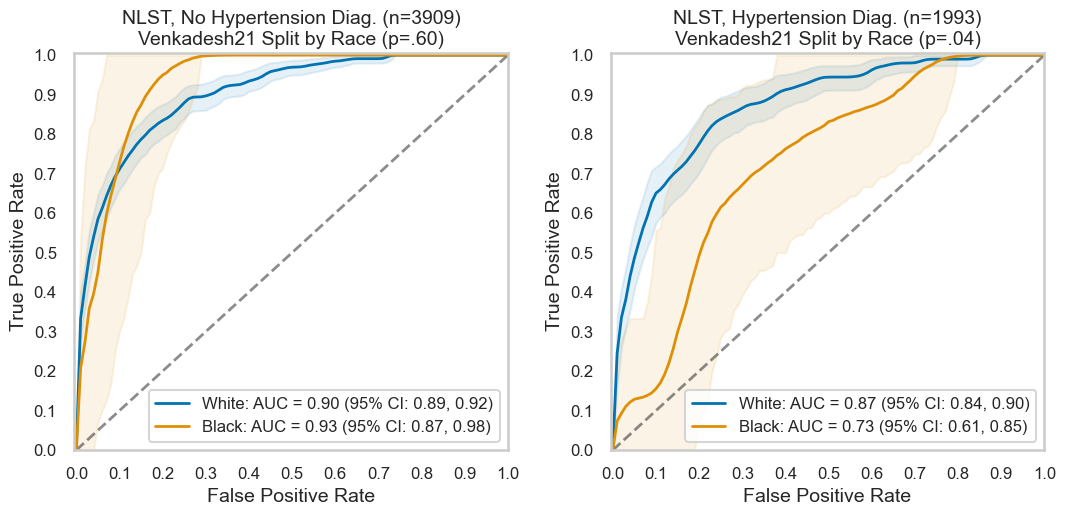

In [128]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'Race',
    'Hypertension Diag.',
    models={'Venkadesh21': 'DL_cal'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/venkROCrace-Hypertension.png"
)

### BMI

In [129]:
bmi_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_prev_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'Sybil (Year 1)',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROC.tex",
    hrules=True, label='tab:bmiIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI participants, and the AUROC scores of the Sybil (Year 1) model between BMI groups isolating for them.'))

bmi_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %              AUROC  Mal   
Confounder             Subset                                              
Weight                 ≤ 180   199  1600    94.7  0.81 (0.78, 0.84)  135   
                       > 180    10    90     5.3  0.93 (0.83, 0.99)  237   
Current Smoker         True    135  1048    62.3  0.81 (0.77, 0.86)  179   
                       False    74   642    37.7  0.82 (0.76, 0.87)  193   
Sex                    Male     92   811    47.6  0.76 (0.70, 0.82)  245   
                       Female  117   879    52.4  0.85 (0.81, 0.89)  127   
Emphysema in Scan      True    103   789    47.0  0.78 (0.73, 0.83)  161   
                       False   106   901    53.0  0.84 (0.79, 0.89)  211   
Hypertension Diag.     False   143  1292    75.6  0.82 (0.78, 0.85)  209   
                       True     62   397    24.2  0.80 (0.73, 0.86)  161   
Height                 > 68     71   680    39.5  0.77 (0.70, 0.83)  196   
                       ≤ 68    138  1010    60.5  0.84 (0.81, 0.88)  176   
Total Years of Smoking ≤ 40     67   707    40.8  0.85 (0.80, 0.90)  124   
                       > 40    142   983    59.2  0.79 (0.75, 0.84)  248   
Smoked Pipe            False   174  1403    83.0  0.83 (0.80, 0.87)  262   
                       True     34   280    16.5  0.74 (0.63, 0.84)  109   
Diabetes Diag.         True      6    62     3.6  0.99 (1.00, 1.00)   51   
                       False   202  1625    96.2  0.81 (0.77, 0.84)  321   
Smoked Cigars          True     27   238    14.0  0.70 (0.59, 0.81)   82   
                       False   181  1446    85.7  0.83 (0.80, 0.87)  289   

                                                                     p  
                                Ben Total %              AUROC          
Confounder             Subset                                           
Weight                 ≤ 180   1161    32.3  0.89 (0.86, 0.92)    .002  
                       > 180   2479    67.7  0.84 (0.81, 0.87)     .12  
Current Smoker         True    1619    44.8  0.86 (0.84, 0.89)     .07  
                       False   2021    55.2  0.85 (0.82, 0.88)     .30  
Sex                    Male    2293    63.3  0.83 (0.80, 0.86)     .03  
                       Female  1347    36.7  0.90 (0.87, 0.93)     .11  
Emphysema in Scan      True    1103    31.5  0.81 (0.77, 0.85)     .44  
                       False   2537    68.5  0.88 (0.86, 0.91)     .10  
Hypertension Diag.     False   2265    61.7  0.88 (0.85, 0.90)     .02  
                       True    1373    38.2  0.82 (0.79, 0.85)     .55  
Height                 > 68    1820    50.2  0.82 (0.78, 0.85)     .19  
                       ≤ 68    1820    49.8  0.89 (0.87, 0.92)     .04  
Total Years of Smoking ≤ 40    1858    49.4  0.84 (0.80, 0.88)     .69  
                       > 40    1782    50.6  0.86 (0.84, 0.88)    .009  
Smoked Pipe            False   2736    74.7  0.86 (0.84, 0.89)     .15  
                       True     878    24.6  0.83 (0.79, 0.87)     .09  
Diabetes Diag.         True     426    11.9  0.82 (0.75, 0.88)  < .001  
                       False   3214    88.1  0.86 (0.84, 0.88)     .01  
Smoked Cigars          True     801    22.0  0.83 (0.79, 0.88)     .02  
                       False   2822    77.5  0.86 (0.83, 0.89)     .23

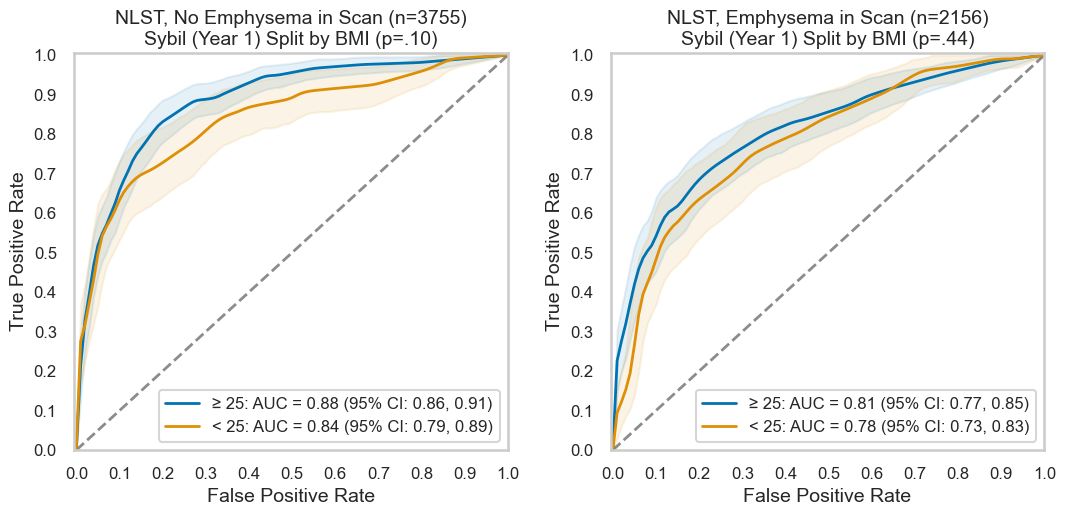

In [130]:
_ = roc.plot_rocs_isolate_confounder(
    nlst_5911,
    'BMI',
    'Emphysema in Scan',
    models={'Sybil (Year 1)': 'sybil_year1'},
    dataset_name="NLST",
    num_bootstraps=1000,
    imgpath=f"{FIG_DIR}/sybilROCbmi-Emphysema.png"
)

In [131]:
bmi_pancan_roc, bmi_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Overweight',
    NLST_POSSIBLE_CONFOUNDERS,
    bmi_roc,
    'PanCan2b',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(bmi_pancan_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiIsolationPlusROCpancan.tex",
    hrules=True, label='tab:bmiIsolationPlusROCpancan', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between high and low BMI participants, and the AUROC scores of the PanCan2b model between BMI groups isolating for them.'))

bmi_pancan_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Group_1_AUC"] = df.apply(
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:539: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

< 25                                  ≥ 25  \
                               Mal   Ben Total %              AUROC  Mal   
Confounder             Subset                                              
Weight                 ≤ 180   199  1600    94.7  0.73 (0.69, 0.76)  135   
                       > 180    10    90     5.3  0.85 (0.68, 0.99)  237   
Current Smoker         True    135  1048    62.3  0.72 (0.67, 0.77)  179   
                       False    74   642    37.7  0.76 (0.70, 0.82)  193   
Sex                    Male     92   811    47.6  0.73 (0.67, 0.78)  245   
                       Female  117   879    52.4  0.74 (0.69, 0.79)  127   
Emphysema in Scan      True    103   789    47.0  0.68 (0.62, 0.73)  161   
                       False   106   901    53.0  0.78 (0.74, 0.83)  211   
Hypertension Diag.     False   143  1292    75.6  0.74 (0.70, 0.78)  209   
                       True     62   397    24.2  0.70 (0.63, 0.77)  161   
Height                 > 68     71   680    39.5  0.70 (0.64, 0.77)  196   
                       ≤ 68    138  1010    60.5  0.75 (0.71, 0.79)  176   
Total Years of Smoking ≤ 40     67   707    40.8  0.80 (0.74, 0.86)  124   
                       > 40    142   983    59.2  0.69 (0.64, 0.74)  248   
Smoked Pipe            False   174  1403    83.0  0.73 (0.69, 0.77)  262   
                       True     34   280    16.5  0.72 (0.63, 0.81)  109   
Diabetes Diag.         True      6    62     3.6  0.96 (0.91, 1.00)   51   
                       False   202  1625    96.2  0.72 (0.69, 0.76)  321   
Smoked Cigars          True     27   238    14.0  0.66 (0.55, 0.77)   82   
                       False   181  1446    85.7  0.74 (0.70, 0.78)  289   

                                                                     p  
                                Ben Total %              AUROC          
Confounder             Subset                                           
Weight                 ≤ 180   1161    32.3  0.82 (0.79, 0.85)  < .001  
                       > 180   2479    67.7  0.80 (0.77, 0.83)     .46  
Current Smoker         True    1619    44.8  0.81 (0.78, 0.84)    .002  
                       False   2021    55.2  0.80 (0.77, 0.83)     .24  
Sex                    Male    2293    63.3  0.81 (0.79, 0.84)     .01  
                       Female  1347    36.7  0.81 (0.78, 0.85)     .02  
Emphysema in Scan      True    1103    31.5  0.80 (0.76, 0.83)  < .001  
                       False   2537    68.5  0.81 (0.78, 0.83)     .43  
Hypertension Diag.     False   2265    61.7  0.82 (0.80, 0.85)    .005  
                       True    1373    38.2  0.78 (0.74, 0.82)     .05  
Height                 > 68    1820    50.2  0.81 (0.78, 0.84)    .004  
                       ≤ 68    1820    49.8  0.81 (0.78, 0.84)     .05  
Total Years of Smoking ≤ 40    1858    49.4  0.82 (0.79, 0.85)     .56  
                       > 40    1782    50.6  0.79 (0.76, 0.82)  < .001  
Smoked Pipe            False   2736    74.7  0.81 (0.79, 0.84)    .002  
                       True     878    24.6  0.80 (0.76, 0.84)     .16  
Diabetes Diag.         True     426    11.9  0.85 (0.80, 0.90)     .06  
                       False   3214    88.1  0.80 (0.78, 0.83)    .001  
Smoked Cigars          True     801    22.0  0.83 (0.79, 0.87)    .008  
                       False   2822    77.5  0.80 (0.78, 0.83)     .01

### Age

In [132]:
age_roc = pd.read_csv(f'{RESULTS_DIR}/auroc-age-by-factors-nlst-5911.csv', index_col=0)
age_prev_roc, age_topn_confounders = output.prevalence_plus_isolated_roc(
    nlst_5911_v2,
    'Age > 61',
    NLST_POSSIBLE_CONFOUNDERS,
    age_roc,
    'PanCan2b',
    topn=TOP_N_CONFOUNDERS,
    result_prec=TABLE_SCORE_PRECISION,
)

print(age_prev_roc.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/ageIsolationPlusROC.tex",
    hrules=True, label='tab:ageIsolationPlusROC', environment='sidewaystable*', column_format=f'll|rrrr|rrrr|r', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'The top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between participants above and below 61 years old, and the AUROC scores of the PanCan2b model between these racial groups isolating for them.'))

age_prev_roc

None


c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df2["Difference"] = cat_df["Difference"]
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:526: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df2.drop(columns=["Difference", "Abs Diff"]).droplevel(0)
c:\Users\shaur\Documents\bodyct-lung-malignancy-fairness\utilities\output.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

≤ 61                                  > 61  \
                                Mal   Ben Total %              AUROC  Mal   
Confounder              Subset                                              
Total Years of Smoking  > 40     98   770    33.6  0.77 (0.72, 0.81)  292   
                        ≤ 40    125  1593    66.4  0.83 (0.79, 0.86)   66   
Current Smoker          False    95  1011    42.8  0.83 (0.79, 0.86)  172   
                        True    128  1352    57.2  0.79 (0.75, 0.83)  186   
Hypertension Diag.      False   150  1677    70.6  0.82 (0.78, 0.85)  202   
                        True     72   686    29.3  0.79 (0.72, 0.84)  151   
Diameter (mm)           ≤ 6      23  1026    40.6  0.64 (0.52, 0.77)   33   
                        > 6     200  1337    59.4  0.76 (0.72, 0.79)  325   
Age at Smoking Onset    > 16     88   971    41.0  0.82 (0.77, 0.86)  146   
                        ≤ 16    135  1392    59.0  0.80 (0.76, 0.84)  212   
Emphysema in Scan       False   131  1610    67.3  0.82 (0.78, 0.86)  186   
                        True     92   753    32.7  0.77 (0.72, 0.82)  172   
Heart Disease or Attack False   196  2127    89.8  0.81 (0.78, 0.84)  296   
                        True     26   231     9.9  0.73 (0.63, 0.83)   61   
Pack-Years              ≤ 55    107  1467    60.9  0.83 (0.78, 0.86)  178   
                        > 55    116   896    39.1  0.78 (0.73, 0.82)  180   
Emphysema Diag.         False   190  2199    92.4  0.80 (0.77, 0.83)  307   
                        True     32   163     7.5  0.81 (0.73, 0.87)   50   
Cigarettes per Day      > 25    129  1171    50.3  0.81 (0.77, 0.85)  172   
                        ≤ 25     94  1192    49.7  0.80 (0.76, 0.84)  186   

                                                                   p  
                                 Ben Total %              AUROC       
Confounder              Subset                                        
Total Years of Smoking  > 40    1995    68.8  0.75 (0.72, 0.78)  .61  
                        ≤ 40     972    31.2  0.80 (0.74, 0.85)  .44  
Current Smoker          False   1652    54.9  0.77 (0.74, 0.81)  .10  
                        True    1315    45.1  0.75 (0.72, 0.78)  .21  
Hypertension Diag.      False   1880    62.6  0.78 (0.75, 0.81)  .16  
                        True    1084    37.1  0.74 (0.70, 0.78)  .26  
Diameter (mm)           ≤ 6     1080    33.5  0.64 (0.55, 0.72)  .91  
                        > 6     1887    66.5  0.71 (0.68, 0.74)  .04  
Age at Smoking Onset    > 16    1450    48.0  0.80 (0.77, 0.84)  .65  
                        ≤ 16    1517    52.0  0.73 (0.70, 0.77)  .03  
Emphysema in Scan       False   1828    60.6  0.78 (0.75, 0.81)  .15  
                        True    1139    39.4  0.73 (0.70, 0.77)  .27  
Heart Disease or Attack False   2468    83.1  0.76 (0.73, 0.78)  .01  
                        True     484    16.4  0.79 (0.74, 0.84)  .34  
Pack-Years              ≤ 55    1638    54.6  0.77 (0.74, 0.80)  .08  
                        > 55    1329    45.4  0.76 (0.72, 0.79)  .46  
Emphysema Diag.         False   2569    86.5  0.77 (0.75, 0.80)  .20  
                        True     390    13.2  0.71 (0.63, 0.77)  .09  
Cigarettes per Day      > 25    1320    44.9  0.77 (0.73, 0.80)  .18  
                        ≤ 25    1647    55.1  0.76 (0.73, 0.80)  .23

## Sensitivity and Specificity

### Sex

In [70]:
gender_pairwise_comps = None

In [71]:
gender_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-gender-by-factors-nlst-5911.csv', index_col=0)
gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
gender_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                   Male             Female   
Confounder         Subset                                                    
Height             > 68               0.52 (0.46, 0.59)  0.60 (0.29, 0.92)   
                   ≤ 68               0.55 (0.45, 0.67)  0.66 (0.60, 0.72)   
Weight             > 180              0.56 (0.49, 0.62)  0.64 (0.47, 0.80)   
                   ≤ 180              0.48 (0.39, 0.56)  0.66 (0.59, 0.72)   
Smoked Pipe        False              0.56 (0.49, 0.63)  0.65 (0.59, 0.71)   
                   True               0.49 (0.40, 0.57)  1.00 (1.00, 1.00)   
Smoked Cigars      False              0.56 (0.50, 0.62)  0.65 (0.59, 0.71)   
                   True               0.45 (0.36, 0.54)  0.86 (0.50, 1.00)   
Work w/o Mask      False              0.53 (0.46, 0.60)  0.68 (0.62, 0.75)   
                   True               0.52 (0.43, 0.61)  0.47 (0.30, 0.65)   
Pack-Years         > 55               0.54 (0.47, 0.60)  0.73 (0.64, 0.82)   
                   ≤ 55               0.52 (0.44, 0.60)  0.60 (0.52, 0.69)   
BMI                < 25               0.50 (0.40, 0.60)  0.66 (0.58, 0.74)   
                   ≥ 25               0.54 (0.48, 0.60)  0.65 (0.56, 0.74)   
Cigarettes per Day > 25               0.54 (0.47, 0.61)  0.74 (0.65, 0.82)   
                   ≤ 25               0.51 (0.43, 0.60)  0.59 (0.51, 0.67)   
Lived w/ Smoker    False              0.51 (0.35, 0.67)  0.57 (0.35, 0.79)   
                   True               0.53 (0.47, 0.59)  0.67 (0.60, 0.73)   
Pneumonia Diag.    False              0.56 (0.50, 0.61)  0.68 (0.61, 0.75)   
                   True               0.40 (0.28, 0.53)  0.64 (0.54, 0.75)   

                              Specificity (90% Sensitivity)  \
                           CI                          Male   
Confounder         Subset                                     
Height             > 68                   0.45 (0.43, 0.47)   
                   ≤ 68                   0.49 (0.46, 0.53)   
Weight             > 180                  0.48 (0.46, 0.51)   
                   ≤ 180   **             0.42 (0.39, 0.45)   
Smoked Pipe        False    *             0.46 (0.44, 0.48)   
                   True    **             0.47 (0.44, 0.50)   
Smoked Cigars      False    *             0.46 (0.43, 0.48)   
                   True     *             0.48 (0.45, 0.51)   
Work w/o Mask      False   **             0.48 (0.46, 0.50)   
                   True                   0.43 (0.40, 0.46)   
Pack-Years         > 55    **             0.43 (0.41, 0.46)   
                   ≤ 55     *             0.49 (0.47, 0.52)   
BMI                < 25     *             0.41 (0.37, 0.44)   
                   ≥ 25     *             0.48 (0.46, 0.50)   
Cigarettes per Day > 25    **             0.45 (0.43, 0.48)   
                   ≤ 25                   0.48 (0.45, 0.50)   
Lived w/ Smoker    False                  0.46 (0.42, 0.50)   
                   True    **             0.46 (0.44, 0.48)   
Pneumonia Diag.    False    *             0.49 (0.47, 0.51)   
                   True    **             0.35 (0.31, 0.39)   

                                                  
                                      Female  CI  
Confounder         Subset                         
Height             > 68    0.47 (0.39, 0.56)      
                   ≤ 68    0.57 (0.55, 0.59)  **  
Weight             > 180   0.63 (0.59, 0.67)  **  
                   ≤ 180   0.54 (0.52, 0.56)  **  
Smoked Pipe        False   0.56 (0.54, 0.58)  **  
                   True    0.47 (0.33, 0.62)      
Smoked Cigars      False   0.56 (0.53, 0.58)  **  
                   True    0.67 (0.56, 0.77)  **  
Work w/o Mask      False   0.57 (0.55, 0.59)  **  
                   True    0.52 (0.46, 0.57)  **  
Pack-Years         > 55    0.54 (0.50, 0.58)  **  
                   ≤ 55    0.57 (0.55, 0.60)  **  
BMI             

In [ ]:
print(gender_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/genderTPRandTNRisolated.tex",
    hrules=True, label='tab:genderTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% Confidence Intervals) for the Sybil (Year 1) model between men and women, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between sexes. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


### Sex (PanCan2b)

In [73]:
pancan_gender_tpr_tnr, gender_pairwise_comps = output.threshold_isolation_pairwise(
    gender_isolations, "Gender", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=gender_topn_confounders, 
    pairwise_comps=gender_pairwise_comps)
pancan_gender_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                   Male             Female   
Confounder         Subset                                                    
Height             > 68               0.33 (0.27, 0.39)  0.60 (0.29, 0.91)   
                   ≤ 68               0.31 (0.21, 0.43)  0.47 (0.40, 0.53)   
Weight             > 180              0.35 (0.28, 0.41)  0.36 (0.20, 0.52)   
                   ≤ 180              0.29 (0.22, 0.38)  0.49 (0.42, 0.56)   
Smoked Pipe        False              0.32 (0.25, 0.39)  0.47 (0.41, 0.53)   
                   True               0.33 (0.25, 0.41)  0.60 (0.00, 1.00)   
Smoked Cigars      False              0.33 (0.27, 0.40)  0.47 (0.41, 0.53)   
                   True               0.30 (0.22, 0.40)  0.57 (0.17, 1.00)   
Work w/o Mask      False              0.33 (0.26, 0.39)  0.48 (0.41, 0.54)   
                   True               0.32 (0.24, 0.41)  0.43 (0.25, 0.61)   
Pack-Years         > 55               0.30 (0.24, 0.37)  0.50 (0.40, 0.60)   
                   ≤ 55               0.36 (0.29, 0.44)  0.45 (0.37, 0.53)   
BMI                < 25               0.34 (0.24, 0.44)  0.47 (0.38, 0.56)   
                   ≥ 25               0.32 (0.27, 0.38)  0.47 (0.38, 0.56)   
Cigarettes per Day > 25               0.31 (0.25, 0.38)  0.47 (0.37, 0.56)   
                   ≤ 25               0.35 (0.27, 0.42)  0.47 (0.38, 0.56)   
Lived w/ Smoker    False              0.35 (0.21, 0.50)  0.33 (0.14, 0.53)   
                   True               0.32 (0.27, 0.37)  0.49 (0.42, 0.55)   
Pneumonia Diag.    False              0.35 (0.29, 0.40)  0.45 (0.37, 0.53)   
                   True               0.22 (0.12, 0.33)  0.51 (0.40, 0.62)   

                              Specificity (90% Sensitivity)  \
                           CI                          Male   
Confounder         Subset                                     
Height             > 68                   0.49 (0.47, 0.51)   
                   ≤ 68     *             0.53 (0.49, 0.56)   
Weight             > 180                  0.52 (0.50, 0.54)   
                   ≤ 180   **             0.46 (0.43, 0.49)   
Smoked Pipe        False   **             0.51 (0.49, 0.53)   
                   True                   0.49 (0.46, 0.52)   
Smoked Cigars      False   **             0.50 (0.48, 0.53)   
                   True                   0.50 (0.47, 0.53)   
Work w/o Mask      False   **             0.51 (0.49, 0.53)   
                   True                   0.49 (0.46, 0.51)   
Pack-Years         > 55    **             0.48 (0.45, 0.50)   
                   ≤ 55     *             0.52 (0.50, 0.55)   
BMI                < 25     *             0.45 (0.42, 0.49)   
                   ≥ 25    **             0.52 (0.50, 0.54)   
Cigarettes per Day > 25     *             0.49 (0.46, 0.51)   
                   ≤ 25     *             0.51 (0.49, 0.54)   
Lived w/ Smoker    False                  0.50 (0.46, 0.54)   
                   True    **             0.50 (0.48, 0.52)   
Pneumonia Diag.    False    *             0.52 (0.50, 0.54)   
                   True    **             0.44 (0.40, 0.48)   

                                                  
                                      Female  CI  
Confounder         Subset                         
Height             > 68    0.28 (0.21, 0.36)  **  
                   ≤ 68    0.37 (0.36, 0.39)  **  
Weight             > 180   0.38 (0.33, 0.42)  **  
                   ≤ 180   0.37 (0.34, 0.39)  **  
Smoked Pipe        False   0.37 (0.35, 0.39)  **  
                   True    0.33 (0.19, 0.49)   *  
Smoked Cigars      False   0.36 (0.34, 0.38)  **  
                   True    0.45 (0.33, 0.56)      
Work w/o Mask      False   0.37 (0.35, 0.39)  **  
                   True    0.36 (0.30, 0.41)  **  
Pack-Years         > 55    0.37 (0.33, 0.40)  **  
                   ≤ 55    0.37 (0.35, 0.39)  **  
BMI             

### Race

In [74]:
race_pairwise_comps = None

In [75]:
race_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-race-by-factors-nlst-5911.csv', index_col=0)
race_tpr_tnr, race_pairwise_comps = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=race_topn_confounders, 
    pairwise_comps=race_pairwise_comps)
race_tpr_tnr

Sensitivity (90% Specificity)                     \
                                                    White              Black   
Confounder           Subset                                                    
Cigarettes per Day   > 25               0.72 (0.66, 0.77)  0.75 (0.40, 1.00)   
                     ≤ 25               0.65 (0.60, 0.71)  0.25 (0.07, 0.44)   
Pack-Years           > 55               0.71 (0.65, 0.76)  0.60 (0.00, 1.00)   
                     ≤ 55               0.67 (0.61, 0.73)  0.35 (0.16, 0.55)   
Hypertension Diag.   False              0.71 (0.66, 0.76)  0.67 (0.36, 0.92)   
                     True               0.65 (0.58, 0.72)  0.19 (0.00, 0.40)   
Current Smoker       False              0.67 (0.60, 0.72)  0.36 (0.10, 0.67)   
                     True               0.71 (0.65, 0.76)  0.41 (0.17, 0.67)   
Smoked Pipe          False              0.70 (0.65, 0.74)  0.43 (0.23, 0.65)   
                     True               0.65 (0.57, 0.72)  0.20 (0.00, 0.67)   
Sex                  Female             0.72 (0.66, 0.78)  0.40 (0.17, 0.67)   
                     Male               0.66 (0.61, 0.71)  0.38 (0.12, 0.67)   
Diabetes Diag.       False              0.69 (0.64, 0.73)  0.38 (0.18, 0.57)   
                     True               0.72 (0.59, 0.84)  0.50 (0.00, 1.00)   
Height               > 68               0.66 (0.60, 0.72)  0.36 (0.10, 0.70)   
                     ≤ 68               0.71 (0.66, 0.76)  0.41 (0.17, 0.67)   
Work - Farming       False              0.69 (0.64, 0.73)  0.38 (0.19, 0.57)   
                     True               0.71 (0.56, 0.84)  0.50 (0.00, 1.00)   
Age at Smoking Onset > 16               0.73 (0.67, 0.79)  0.39 (0.17, 0.63)   
                     ≤ 16               0.66 (0.61, 0.72)  0.40 (0.12, 0.71)   

                                Specificity (90% Sensitivity)  \
                             CI                         White   
Confounder           Subset                                     
Cigarettes per Day   > 25                   0.66 (0.64, 0.68)   
                     ≤ 25    **             0.66 (0.64, 0.68)   
Pack-Years           > 55                   0.65 (0.63, 0.67)   
                     ≤ 55    **             0.67 (0.65, 0.69)   
Hypertension Diag.   False                  0.67 (0.65, 0.69)   
                     True    **             0.64 (0.62, 0.66)   
Current Smoker       False    *             0.67 (0.65, 0.68)   
                     True     *             0.65 (0.63, 0.67)   
Smoked Pipe          False   **             0.66 (0.65, 0.68)   
                     True                   0.65 (0.63, 0.68)   
Sex                  Female   *             0.68 (0.66, 0.70)   
                     Male                   0.65 (0.63, 0.66)   
Diabetes Diag.       False   **             0.66 (0.65, 0.67)   
                     True                   0.66 (0.61, 0.70)   
Height               > 68                   0.64 (0.62, 0.66)   
                     ≤ 68     *             0.68 (0.66, 0.70)   
Work - Farming       False   **             0.66 (0.65, 0.68)   
                     True                   0.64 (0.61, 0.68)   
Age at Smoking Onset > 16    **             0.67 (0.65, 0.69)   
                     ≤ 16                   0.65 (0.64, 0.67)   

                                                    
                                         Black  CI  
Confounder           Subset                         
Cigarettes per Day   > 25    0.70 (0.53, 0.85)      
                     ≤ 25    0.74 (0.67, 0.81)   *  
Pack-Years           > 55    0.71 (0.54, 0.85)      
                     ≤ 55    0.74 (0.66, 0.82)      
Hypertension Diag.   False   0.72 (0.61, 0.82)      
                     True    0.74 (0.65, 0.84)   *  
Current Smoker       False   0.77 (0.65, 0.89)      
                     True    0.71 (0.63, 0.80)      
Smoked Pipe          False   0.71 (0.64, 0.78)      
                     True    0.92 (0.73, 1.00)  **  
Se

In [76]:
print(race_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/raceTPRandTNRisolated.tex",
    hrules=True, label='tab:raceTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% Confidence Intervals) for the Venkadesh21 model between between White and Black participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between racial groups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [77]:
all_race_tpr_tnr, _ = output.threshold_isolation_pairwise(
    race_isolations, "WhiteOrBlack", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=None, 
    pairwise_comps=race_pairwise_comps)

In [78]:
all_race_tpr_tnr[all_race_tpr_tnr.index.get_level_values(0).str.contains('Nodule')]

Sensitivity (90% Specificity)                     \
                                                    White              Black   
Confounder           Subset                                                    
Calcified Nodule     False              0.69 (0.65, 0.73)  0.39 (0.21, 0.58)   
Ground-Glass Nodule  False              0.69 (0.65, 0.73)  0.39 (0.21, 0.57)   
                     True                  nan (nan, nan)     nan (nan, nan)   
Nodule in Upper Lung False              0.70 (0.64, 0.76)  0.54 (0.25, 0.80)   
                     True               0.68 (0.63, 0.73)  0.27 (0.06, 0.50)   
Non-Solid Nodule     False              0.72 (0.68, 0.76)  0.42 (0.23, 0.61)   
                     True               0.36 (0.24, 0.50)  0.00 (0.00, 0.00)   
Part-Solid Nodule    False              0.67 (0.63, 0.71)  0.42 (0.22, 0.61)   
                     True               0.80 (0.71, 0.88)  0.25 (0.00, 0.75)   
Perfissural Nodule   False              0.69 (0.65, 0.73)  0.39 (0.21, 0.58)   
                     True                  nan (nan, nan)     nan (nan, nan)   
Semi-Solid Nodule    False              0.69 (0.65, 0.73)  0.39 (0.22, 0.59)   
                     True                  nan (nan, nan)     nan (nan, nan)   
Solid Nodule         False              0.63 (0.55, 0.72)  0.00 (0.00, 0.00)   
                     True               0.71 (0.67, 0.75)  0.48 (0.26, 0.69)   
Spiculated Nodule    False              0.68 (0.64, 0.72)  0.39 (0.21, 0.58)   
Nodules Per Scan     > 1                0.72 (0.68, 0.77)  0.45 (0.24, 0.67)   
                     ≤ 1                0.60 (0.51, 0.68)  0.25 (0.00, 0.62)   

                                Specificity (90% Sensitivity)  \
                             CI                         White   
Confounder           Subset                                     
Calcified Nodule     False   **             0.66 (0.65, 0.67)   
Ground-Glass Nodule  False   **             0.64 (0.63, 0.66)   
                     True                   0.70 (0.67, 0.72)   
Nodule in Upper Lung False                  0.75 (0.73, 0.77)   
                     True    **             0.57 (0.56, 0.59)   
Non-Solid Nodule     False   **             0.66 (0.65, 0.67)   
                     True    **                nan (nan, nan)   
Part-Solid Nodule    False   **             0.66 (0.65, 0.67)   
                     True     *                nan (nan, nan)   
Perfissural Nodule   False   **             0.65 (0.64, 0.67)   
                     True                   0.71 (0.68, 0.75)   
Semi-Solid Nodule    False   **             0.70 (0.69, 0.71)   
                     True                   0.41 (0.38, 0.44)   
Solid Nodule         False   **             0.70 (0.68, 0.72)   
                     True     *             0.64 (0.63, 0.66)   
Spiculated Nodule    False   **             0.66 (0.65, 0.67)   
Nodules Per Scan     > 1     **             0.59 (0.57, 0.61)   
                     ≤ 1                    0.72 (0.70, 0.74)   

                                                    
                                         Black  CI  
Confounder           Subset                         
Calcified Nodule     False   0.73 (0.66, 0.80)   *  
Ground-Glass Nodule  False   0.72 (0.63, 0.81)      
                     True    0.75 (0.63, 0.85)      
Nodule in Upper Lung False   0.81 (0.70, 0.89)      
                     True    0.66 (0.56, 0.77)      
Non-Solid Nodule     False   0.73 (0.67, 0.80)   *  
                     True       nan (nan, nan)      
Part-Solid Nodule    False   0.73 (0.66, 0.80)      
                     True       nan (nan, nan)      
Perfissural Nodule   False   0.71 (0.64, 0.78)      
                     True    0.93 (0.80, 1.00)  **  
Semi-Solid Nodule    False   0.80 (0.73, 0.87)  **  
                     True    0.41 (0.24, 0.59)      
Solid Nodule         False   0.75 (0.65, 0.85)      
                     True    0.71 (0.62, 0.80)      
Spiculated Nodule    False 

### BMI

In [79]:
bmi_pairwise_comps = None

In [80]:
bmi_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-bmi-by-factors-nlst-5911.csv', index_col=0)
bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)
bmi_tpr_tnr

Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.56 (0.50, 0.62)   
                       ≤ 180              0.61 (0.52, 0.69)   
Current Smoker         False              0.57 (0.50, 0.64)   
                       True               0.59 (0.52, 0.66)   
Sex                    Female             0.65 (0.57, 0.74)   
                       Male               0.54 (0.48, 0.60)   
Emphysema in Scan      False              0.60 (0.54, 0.66)   
                       True               0.55 (0.47, 0.63)   
Hypertension Diag.     False              0.63 (0.57, 0.70)   
                       True               0.51 (0.43, 0.58)   
Height                 > 68               0.54 (0.46, 0.61)   
                       ≤ 68               0.62 (0.55, 0.70)   
Total Years of Smoking > 40               0.59 (0.53, 0.65)   
                       ≤ 40               0.56 (0.47, 0.64)   
Smoked Pipe            False              0.60 (0.54, 0.67)   
                       True               0.51 (0.42, 0.61)   
Diabetes Diag.         False              0.57 (0.52, 0.63)   
                       True               0.61 (0.47, 0.72)   
Smoked Cigars          False              0.60 (0.54, 0.66)   
                       True               0.50 (0.39, 0.60)   

                                                      \
                                            < 25  CI   
Confounder             Subset                          
Weight                 > 180   0.80 (0.50, 1.00)       
                       ≤ 180   0.58 (0.51, 0.64)       
Current Smoker         False   0.57 (0.45, 0.69)       
                       True    0.60 (0.52, 0.68)       
Sex                    Female  0.66 (0.57, 0.75)       
                       Male    0.50 (0.40, 0.61)       
Emphysema in Scan      False   0.60 (0.50, 0.70)       
                       True    0.57 (0.48, 0.67)       
Hypertension Diag.     False   0.56 (0.49, 0.64)       
                       True    0.65 (0.53, 0.77)   *   
Height                 > 68    0.49 (0.38, 0.61)       
                       ≤ 68    0.64 (0.55, 0.72)       
Total Years of Smoking > 40    0.59 (0.52, 0.67)       
                       ≤ 40    0.58 (0.47, 0.70)       
Smoked Pipe            False   0.61 (0.55, 0.69)       
                       True    0.47 (0.30, 0.65)       
Diabetes Diag.         False   0.58 (0.51, 0.65)       
                       True    1.00 (1.00, 1.00)  **   
Smoked Cigars          False   0.62 (0.55, 0.68)       
                       True    0.41 (0.22, 0.60)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.51 (0.49, 0.53)   
                       ≤ 180              0.55 (0.52, 0.58)   
Current Smoker         False              0.52 (0.50, 0.55)   
                       True               0.53 (0.50, 0.55)   
Sex                    Female             0.60 (0.57, 0.62)   
                       Male               0.48 (0.46, 0.50)   
Emphysema in Scan      False              0.56 (0.54, 0.58)   
                       True               0.44 (0.42, 0.47)   
Hypertension Diag.     False              0.55 (0.53, 0.57)   
                       True               0.48 (0.46, 0.51)   
Height                 > 68               0.48 (0.45, 0.50)   
                       ≤ 68               0.57 (0.55, 0.59)   
Total Years of Smoking > 40               0.49 (0.46, 0.51)   
                       ≤ 40               0.56 (0.54, 0.58)   
Smoked Pipe            False              0.54 (0.52, 0.56)   
                       True               0.49 (0.45, 0.52)   
Diabetes Diag.         False              0.53 (0.51, 0.54)   
                       True    

In [81]:
print(bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolated.tex",
    hrules=True, label='tab:bmiTPRandTNRisolated', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% Confidence Intervals) for the Sybil (Year 1) model between between high and low BMI participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

None


In [82]:
pancan_bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)

print(pancan_bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolatedPanCan.tex",
    hrules=True, label='tab:bmiTPRandTNRisolatedPanCan', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% Confidence Intervals) for the PanCan2b model between between high and low BMI participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))

pancan_bmi_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.34 (0.28, 0.40)   
                       ≤ 180              0.43 (0.34, 0.52)   
Current Smoker         False              0.36 (0.29, 0.43)   
                       True               0.39 (0.32, 0.46)   
Sex                    Female             0.47 (0.39, 0.56)   
                       Male               0.32 (0.27, 0.38)   
Emphysema in Scan      False              0.33 (0.27, 0.39)   
                       True               0.43 (0.35, 0.50)   
Hypertension Diag.     False              0.38 (0.31, 0.45)   
                       True               0.37 (0.30, 0.44)   
Height                 > 68               0.34 (0.28, 0.41)   
                       ≤ 68               0.41 (0.34, 0.48)   
Total Years of Smoking > 40               0.40 (0.33, 0.45)   
                       ≤ 40               0.33 (0.25, 0.42)   
Smoked Pipe            False              0.39 (0.32, 0.45)   
                       True               0.35 (0.26, 0.44)   
Diabetes Diag.         False              0.36 (0.31, 0.41)   
                       True               0.45 (0.31, 0.58)   
Smoked Cigars          False              0.40 (0.34, 0.45)   
                       True               0.29 (0.19, 0.39)   

                                                     \
                                            < 25 CI   
Confounder             Subset                         
Weight                 > 180   0.50 (0.18, 0.83)      
                       ≤ 180   0.41 (0.34, 0.48)      
Current Smoker         False   0.43 (0.32, 0.55)      
                       True    0.40 (0.31, 0.48)      
Sex                    Female  0.47 (0.38, 0.56)      
                       Male    0.34 (0.24, 0.44)      
Emphysema in Scan      False   0.43 (0.35, 0.53)  *   
                       True    0.39 (0.29, 0.49)      
Hypertension Diag.     False   0.44 (0.36, 0.52)      
                       True    0.35 (0.24, 0.48)      
Height                 > 68    0.34 (0.23, 0.45)      
                       ≤ 68    0.45 (0.37, 0.53)      
Total Years of Smoking > 40    0.35 (0.27, 0.43)      
                       ≤ 40    0.54 (0.42, 0.66)  *   
Smoked Pipe            False   0.43 (0.35, 0.50)      
                       True    0.32 (0.17, 0.48)      
Diabetes Diag.         False   0.40 (0.34, 0.47)      
                       True    0.67 (0.25, 1.00)      
Smoked Cigars          False   0.41 (0.34, 0.48)      
                       True    0.41 (0.21, 0.58)      

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.49 (0.47, 0.51)   
                       ≤ 180              0.43 (0.40, 0.46)   
Current Smoker         False              0.46 (0.43, 0.48)   
                       True               0.49 (0.46, 0.51)   
Sex                    Female             0.39 (0.36, 0.41)   
                       Male               0.52 (0.50, 0.54)   
Emphysema in Scan      False              0.50 (0.48, 0.52)   
                       True               0.40 (0.37, 0.43)   
Hypertension Diag.     False              0.49 (0.47, 0.52)   
                       True               0.43 (0.40, 0.46)   
Height                 > 68               0.50 (0.48, 0.53)   
                       ≤ 68               0.44 (0.41, 0.46)   
Total Years of Smoking > 40               0.44 (0.42, 0.47)   
                       ≤ 40               0.50 (0.47, 0.52)   
Smoked Pipe            False              0.46 (0.45, 0.48)   
                       True               0.49 (0.46, 0.53)   
Diabetes Diag.         False              0.47 (0.46, 0.49)   
                       True               0.45 (0.40, 

In [83]:
venk_bmi_tpr_tnr, bmi_pairwise_comps = output.threshold_isolation_pairwise(
    bmi_isolations, "Overweight", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=bmi_topn_confounders, 
    pairwise_comps=bmi_pairwise_comps)

print(venk_bmi_tpr_tnr.style
        .format(output.latex_replace_arrowbrackets, escape='latex-math', na_rep='')
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=1)
        .format_index(output.latex_replace_arrowbrackets, escape='latex-math', axis=0)
        .to_latex(
    buf=f"{TAB_DIR}/bmiTPRandTNRisolatedVenk21.tex",
    hrules=True, label='tab:bmiTPRandTNRisolatedVenk21', environment='sidewaystable*', column_format=f'll|rrr|rrr', position='h!',
    multirow_align='c', multicol_align='c',  position_float='centering', clines='skip-last;data', siunitx=True,
    caption=f'Sensitivity and Specificity at specific thresholds (with 95\% Confidence Intervals) for the Venkadesh21 model between between high and low BMI participants, isolating for the top {TOP_N_CONFOUNDERS} characteristics with the largest prevalence difference between subgroups. Single asterisk (*) = metric of one subgroup is outside the CI of the other. Double asterisks (**) = CIs do not intersect.'))


venk_bmi_tpr_tnr

None


Sensitivity (90% Specificity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.68 (0.62, 0.74)   
                       ≤ 180              0.67 (0.59, 0.74)   
Current Smoker         False              0.65 (0.58, 0.71)   
                       True               0.71 (0.64, 0.77)   
Sex                    Female             0.68 (0.60, 0.76)   
                       Male               0.68 (0.62, 0.74)   
Emphysema in Scan      False              0.69 (0.63, 0.76)   
                       True               0.66 (0.58, 0.73)   
Hypertension Diag.     False              0.74 (0.68, 0.80)   
                       True               0.60 (0.52, 0.68)   
Height                 > 68               0.67 (0.61, 0.74)   
                       ≤ 68               0.68 (0.61, 0.75)   
Total Years of Smoking > 40               0.70 (0.65, 0.75)   
                       ≤ 40               0.63 (0.55, 0.71)   
Smoked Pipe            False              0.68 (0.62, 0.74)   
                       True               0.67 (0.58, 0.76)   
Diabetes Diag.         False              0.68 (0.62, 0.73)   
                       True               0.69 (0.55, 0.81)   
Smoked Cigars          False              0.70 (0.65, 0.75)   
                       True               0.59 (0.47, 0.69)   

                                                      \
                                            < 25  CI   
Confounder             Subset                          
Weight                 > 180   0.60 (0.29, 0.90)       
                       ≤ 180   0.69 (0.63, 0.76)       
Current Smoker         False   0.70 (0.60, 0.80)       
                       True    0.68 (0.60, 0.76)       
Sex                    Female  0.74 (0.66, 0.83)       
                       Male    0.62 (0.52, 0.72)       
Emphysema in Scan      False   0.65 (0.56, 0.74)       
                       True    0.73 (0.64, 0.81)       
Hypertension Diag.     False   0.69 (0.61, 0.76)       
                       True    0.69 (0.59, 0.81)       
Height                 > 68    0.62 (0.51, 0.73)       
                       ≤ 68    0.72 (0.65, 0.80)       
Total Years of Smoking > 40    0.71 (0.63, 0.78)       
                       ≤ 40    0.64 (0.52, 0.76)       
Smoked Pipe            False   0.71 (0.65, 0.78)       
                       True    0.59 (0.41, 0.74)       
Diabetes Diag.         False   0.68 (0.62, 0.74)       
                       True    1.00 (1.00, 1.00)  **   
Smoked Cigars          False   0.71 (0.64, 0.77)       
                       True    0.59 (0.39, 0.77)       

                              Specificity (90% Sensitivity)  \
                                                       ≥ 25   
Confounder             Subset                                 
Weight                 > 180              0.68 (0.66, 0.70)   
                       ≤ 180              0.69 (0.66, 0.72)   
Current Smoker         False              0.69 (0.67, 0.71)   
                       True               0.68 (0.65, 0.70)   
Sex                    Female             0.70 (0.68, 0.73)   
                       Male               0.67 (0.65, 0.69)   
Emphysema in Scan      False              0.70 (0.68, 0.71)   
                       True               0.65 (0.62, 0.67)   
Hypertension Diag.     False              0.70 (0.68, 0.72)   
                       True               0.66 (0.63, 0.68)   
Height                 > 68               0.67 (0.64, 0.69)   
                       ≤ 68               0.70 (0.68, 0.72)   
Total Years of Smoking > 40               0.66 (0.64, 0.69)   
                       ≤ 40               0.70 (0.68, 0.72)   
Smoked Pipe            False              0.68 (0.67, 0.70)   
                       True               0.68 (0.65, 0.71)   
Diabetes Diag.         False              0.68 (0.67, 0.70)   
                       True    

### Age

In [84]:
age_pairwise_comps = None

In [85]:
age_isolations = pd.read_csv(f'{RESULTS_DIR}/threshold-age-by-factors-nlst-5911.csv', index_col=0)
sybil_age_tpr_tnr, age_pairwise_comps = output.threshold_isolation_pairwise(
    age_isolations, "Age > 61", "Sybil (Year 1)", 
    nlst_5911_policies, 
    topn_confs=age_topn_confounders, 
    pairwise_comps=age_pairwise_comps)

sybil_age_tpr_tnr

Sensitivity (90% Specificity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.56 (0.46, 0.66)   
                        ≤ 40               0.51 (0.43, 0.60)   
Current Smoker          False              0.58 (0.49, 0.68)   
                        True               0.50 (0.42, 0.59)   
Hypertension Diag.      False              0.54 (0.46, 0.62)   
                        True               0.53 (0.42, 0.65)   
Diameter (mm)           > 6                0.58 (0.51, 0.64)   
                        ≤ 6                0.13 (0.00, 0.28)   
Age at Smoking Onset    > 16               0.49 (0.39, 0.59)   
                        ≤ 16               0.56 (0.48, 0.65)   
Emphysema in Scan       False              0.60 (0.52, 0.68)   
                        True               0.43 (0.33, 0.53)   
Heart Disease or Attack False              0.53 (0.46, 0.60)   
                        True               0.62 (0.42, 0.81)   
Pack-Years              > 55               0.53 (0.45, 0.62)   
                        ≤ 55               0.53 (0.44, 0.62)   
Emphysema Diag.         False              0.52 (0.45, 0.59)   
                        True               0.62 (0.45, 0.79)   
Cigarettes per Day      > 25               0.55 (0.46, 0.64)   
                        ≤ 25               0.51 (0.41, 0.61)   

                                                       \
                                             > 61  CI   
Confounder              Subset                          
Total Years of Smoking  > 40    0.60 (0.55, 0.65)       
                        ≤ 40    0.67 (0.54, 0.78)   *   
Current Smoker          False   0.56 (0.49, 0.63)       
                        True    0.66 (0.59, 0.73)   *   
Hypertension Diag.      False   0.65 (0.58, 0.71)   *   
                        True    0.56 (0.48, 0.64)       
Diameter (mm)           > 6     0.66 (0.61, 0.72)   *   
                        ≤ 6     0.09 (0.00, 0.21)       
Age at Smoking Onset    > 16    0.69 (0.61, 0.76)  **   
                        ≤ 16    0.56 (0.49, 0.62)       
Emphysema in Scan       False   0.60 (0.53, 0.67)       
                        True    0.62 (0.55, 0.69)  **   
Heart Disease or Attack False   0.60 (0.54, 0.67)   *   
                        True    0.66 (0.53, 0.78)       
Pack-Years              > 55    0.64 (0.57, 0.71)   *   
                        ≤ 55    0.58 (0.52, 0.65)       
Emphysema Diag.         False   0.60 (0.54, 0.66)   *   
                        True    0.70 (0.56, 0.82)       
Cigarettes per Day      > 25    0.66 (0.59, 0.72)   *   
                        ≤ 25    0.57 (0.51, 0.64)       

                               Specificity (90% Sensitivity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.53 (0.50, 0.56)   
                        ≤ 40               0.59 (0.57, 0.61)   
Current Smoker          False              0.58 (0.55, 0.61)   
                        True               0.56 (0.54, 0.59)   
Hypertension Diag.      False              0.58 (0.56, 0.60)   
                        True               0.54 (0.50, 0.57)   
Diameter (mm)           > 6                0.42 (0.40, 0.45)   
                        ≤ 6                0.76 (0.73, 0.78)   
Age at Smoking Onset    > 16               0.60 (0.57, 0.63)   
                        ≤ 16               0.55 (0.53, 0.58)   
Emphysema in Scan       False              0.60 (0.58, 0.63)   
                        True               0.49 (0.46, 0.53)   
Heart Disease or Attack False              0.58 (0.56, 0.60)   
                        True               0.47 (0.40, 0.53)   
Pack-Years              > 55               0.52 (0.49, 0.55)   
                        ≤ 55               0.60 (0.57, 0.62)   
Emphysema Diag.         False 

In [86]:
venk_age_tpr_tnr, age_pairwise_comps = output.threshold_isolation_pairwise(
    age_isolations, "Age > 61", "Venkadesh21", 
    nlst_5911_policies, 
    topn_confs=age_topn_confounders, 
    pairwise_comps=age_pairwise_comps)

venk_age_tpr_tnr

Sensitivity (90% Specificity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.67 (0.58, 0.77)   
                        ≤ 40               0.62 (0.54, 0.71)   
Current Smoker          False              0.63 (0.53, 0.73)   
                        True               0.66 (0.58, 0.73)   
Hypertension Diag.      False              0.69 (0.61, 0.76)   
                        True               0.57 (0.46, 0.68)   
Diameter (mm)           > 6                0.69 (0.61, 0.74)   
                        ≤ 6                0.30 (0.12, 0.50)   
Age at Smoking Onset    > 16               0.59 (0.48, 0.69)   
                        ≤ 16               0.68 (0.60, 0.76)   
Emphysema in Scan       False              0.63 (0.54, 0.70)   
                        True               0.67 (0.57, 0.77)   
Heart Disease or Attack False              0.65 (0.58, 0.72)   
                        True               0.65 (0.45, 0.83)   
Pack-Years              > 55               0.67 (0.59, 0.76)   
                        ≤ 55               0.62 (0.53, 0.71)   
Emphysema Diag.         False              0.64 (0.57, 0.71)   
                        True               0.69 (0.53, 0.84)   
Cigarettes per Day      > 25               0.71 (0.63, 0.78)   
                        ≤ 25               0.56 (0.47, 0.66)   

                                                      \
                                             > 61 CI   
Confounder              Subset                         
Total Years of Smoking  > 40    0.72 (0.67, 0.77)      
                        ≤ 40    0.65 (0.54, 0.77)      
Current Smoker          False   0.68 (0.61, 0.75)      
                        True    0.73 (0.66, 0.79)      
Hypertension Diag.      False   0.74 (0.67, 0.80)      
                        True    0.66 (0.58, 0.73)      
Diameter (mm)           > 6     0.76 (0.71, 0.80)  *   
                        ≤ 6     0.18 (0.06, 0.32)      
Age at Smoking Onset    > 16    0.77 (0.69, 0.83)  *   
                        ≤ 16    0.66 (0.60, 0.72)      
Emphysema in Scan       False   0.72 (0.65, 0.78)  *   
                        True    0.69 (0.62, 0.76)      
Heart Disease or Attack False   0.69 (0.64, 0.75)      
                        True    0.77 (0.65, 0.87)      
Pack-Years              > 55    0.73 (0.67, 0.80)      
                        ≤ 55    0.67 (0.60, 0.74)      
Emphysema Diag.         False   0.71 (0.66, 0.76)  *   
                        True    0.68 (0.54, 0.82)      
Cigarettes per Day      > 25    0.74 (0.67, 0.80)      
                        ≤ 25    0.67 (0.61, 0.74)  *   

                               Specificity (90% Sensitivity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.68 (0.65, 0.71)   
                        ≤ 40               0.70 (0.68, 0.73)   
Current Smoker          False              0.69 (0.66, 0.72)   
                        True               0.70 (0.68, 0.72)   
Hypertension Diag.      False              0.70 (0.68, 0.72)   
                        True               0.69 (0.66, 0.72)   
Diameter (mm)           > 6                0.54 (0.51, 0.56)   
                        ≤ 6                0.90 (0.88, 0.92)   
Age at Smoking Onset    > 16               0.71 (0.68, 0.74)   
                        ≤ 16               0.68 (0.66, 0.71)   
Emphysema in Scan       False              0.71 (0.69, 0.73)   
                        True               0.66 (0.63, 0.69)   
Heart Disease or Attack False              0.70 (0.68, 0.72)   
                        True               0.61 (0.55, 0.68)   
Pack-Years              > 55               0.67 (0.64, 0.70)   
                        ≤ 55               0.71 (0.69, 0.74)   
Emphysema Diag.         False              0.70 (0.69

In [87]:
pancan_age_tpr_tnr, age_pairwise_comps = output.threshold_isolation_pairwise(
    age_isolations, "Age > 61", "PanCan2b", 
    nlst_5911_policies, 
    topn_confs=age_topn_confounders, 
    pairwise_comps=age_pairwise_comps)

pancan_age_tpr_tnr

Sensitivity (90% Specificity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.38 (0.27, 0.47)   
                        ≤ 40               0.37 (0.29, 0.45)   
Current Smoker          False              0.33 (0.24, 0.42)   
                        True               0.41 (0.32, 0.50)   
Hypertension Diag.      False              0.37 (0.29, 0.44)   
                        True               0.39 (0.27, 0.50)   
Diameter (mm)           > 6                0.41 (0.35, 0.48)   
                        ≤ 6                0.00 (0.00, 0.00)   
Age at Smoking Onset    > 16               0.33 (0.24, 0.43)   
                        ≤ 16               0.40 (0.31, 0.48)   
Emphysema in Scan       False              0.34 (0.27, 0.43)   
                        True               0.41 (0.31, 0.51)   
Heart Disease or Attack False              0.40 (0.33, 0.46)   
                        True               0.19 (0.06, 0.36)   
Pack-Years              > 55               0.34 (0.26, 0.43)   
                        ≤ 55               0.40 (0.32, 0.50)   
Emphysema Diag.         False              0.36 (0.29, 0.43)   
                        True               0.47 (0.30, 0.63)   
Cigarettes per Day      > 25               0.34 (0.25, 0.42)   
                        ≤ 25               0.41 (0.32, 0.51)   

                                                      \
                                             > 61 CI   
Confounder              Subset                         
Total Years of Smoking  > 40    0.38 (0.33, 0.44)      
                        ≤ 40    0.47 (0.35, 0.58)      
Current Smoker          False   0.41 (0.34, 0.48)      
                        True    0.38 (0.31, 0.45)      
Hypertension Diag.      False   0.43 (0.36, 0.50)      
                        True    0.35 (0.27, 0.43)      
Diameter (mm)           > 6     0.44 (0.39, 0.49)      
                        ≤ 6     0.00 (0.00, 0.00)      
Age at Smoking Onset    > 16    0.46 (0.37, 0.54)  *   
                        ≤ 16    0.35 (0.29, 0.43)      
Emphysema in Scan       False   0.38 (0.31, 0.46)      
                        True    0.41 (0.34, 0.49)      
Heart Disease or Attack False   0.38 (0.33, 0.44)      
                        True    0.48 (0.36, 0.60)  *   
Pack-Years              > 55    0.38 (0.31, 0.46)      
                        ≤ 55    0.41 (0.34, 0.48)      
Emphysema Diag.         False   0.40 (0.35, 0.46)      
                        True    0.36 (0.23, 0.50)      
Cigarettes per Day      > 25    0.38 (0.31, 0.45)      
                        ≤ 25    0.41 (0.34, 0.47)      

                               Specificity (90% Sensitivity)  \
                                                        ≤ 61   
Confounder              Subset                                 
Total Years of Smoking  > 40               0.49 (0.45, 0.52)   
                        ≤ 40               0.52 (0.50, 0.55)   
Current Smoker          False              0.50 (0.47, 0.53)   
                        True               0.52 (0.49, 0.54)   
Hypertension Diag.      False              0.53 (0.50, 0.55)   
                        True               0.48 (0.44, 0.52)   
Diameter (mm)           > 6                0.19 (0.17, 0.21)   
                        ≤ 6                0.93 (0.92, 0.95)   
Age at Smoking Onset    > 16               0.51 (0.48, 0.54)   
                        ≤ 16               0.51 (0.49, 0.54)   
Emphysema in Scan       False              0.55 (0.52, 0.57)   
                        True               0.44 (0.40, 0.47)   
Heart Disease or Attack False              0.52 (0.49, 0.54)   
                        True               0.47 (0.41, 0.53)   
Pack-Years              > 55               0.49 (0.46, 0.53)   
                        ≤ 55               0.52 (0.50, 0.55)   
Emphysema Diag.         False              0.52 (0.50